In [1]:
# Numpy and Pandas
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from numpy import mean
from numpy import std
import time
from  Self_Attention import *
# Iterative Stratification untuk cross validation multilabel
from skmultilearn.model_selection import IterativeStratification
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support, roc_curve
#Import Tensorflow dan extension
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import  EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.optimizers import Adam, Nadam, Adagrad, SGD, RMSprop, Adadelta
import xgboost as xgb
#Import keras tuner dan metrics untuk tuning parameter
import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization, Sklearn
from sklearn import metrics
import tensorflow_addons as tfa

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support, roc_curve
from sklearn.model_selection import StratifiedKFold,KFold
from skopt import BayesSearchCV
import time

#
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

D:\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#Fungsi model SAE
def sae_model(xt, xv = None, EPOCHS = 100,BATCH_SIZE = 32, opt = "adam", 
              hl_node = 1024, lr = 0.01,af = "relu",num_layers = 3, do=0.5, fr_node = 0.5,
              verbose = 0,return_fe = False):
  #Setting result placeholders
  xt_ae = [] ;xv_ae = [] ; w_ae = []
  #If validation set is not present, use train set as validation set
  if xv is None :
    xv = xt.copy()
  opt = tf.keras.optimizers.get(opt) #Set optimizer
  K.set_value(opt.learning_rate, lr) #Set learning rate

  #Stacked Autoencoder architecture
  for n_layers in range(num_layers):
    #Autoencoder
    inp = Input(shape=(xt.shape[1],))
    #Apply Dropout
    hidden_layer = Dropout(do)(inp)
    #Layer encoder (jumlah layer sesuai dengan n_layers)
    enc = Dense(int(hl_node*(fr_node**n_layers)), activation = af)(hidden_layer)  
    #Layer Decoder
    dec = Dense(xt.shape[1],activation="linear")(enc)
    ae = Model(inp, dec)
    #Compile model
    ae.compile(optimizer=opt, loss='mean_squared_error')
    #EarlyStop jika sudah konvergen 
    es = EarlyStopping(monitor='val_loss', patience=15, verbose=verbose)
    #Latih model
    ae.fit(xt, xt, 
           epochs=EPOCHS,batch_size=BATCH_SIZE, 
           shuffle=True, callbacks = [es] , verbose = verbose,
           validation_data = (xv,xv))
    #Ekstrak Feature extraction
    fe = Model(ae.input, enc)
    #Simpan data hasil latih
    xt = fe.predict(xt) ; xt_ae.append(xt)
    xv = fe.predict(xv) ; xv_ae.append(xv)
    #Simpan bobot hasil latih SAE
    w_ae.append([layer_name for layer_name in ae.layers if "dense" in layer_name.name][0].get_weights())
    if verbose:
      print("Layer {} trained".format(n_layers+1))

  return (w_ae,xv) if return_fe else w_ae

In [3]:
#Fungsi DNN
def dnn_model(xt, n_outputs = 1, sae_weights = None, EPOCHS = 100,BATCH_SIZE = 32, opt = "adam",
              hl_node = 1024, lr = 0.01,af = "relu",num_layers = 3, do=0.5, fr_node = 0.5):
  opt = tf.keras.optimizers.get(opt) #Set optimizer
  K.set_value(opt.learning_rate, lr) #Set learning rate
  
  #Model architecture
  input_layer = Input(shape=(xt.shape[1],))
  hidden_layer = BatchNormalization()(input_layer)
  hidden_layer = Dropout(do)(hidden_layer)
#Set jumlah hidden layer
  for n_layers in range(num_layers):
    hidden_layer = Dense(int(hl_node*(fr_node**n_layers)), activation = af)(hidden_layer)
    hidden_layer = BatchNormalization()(hidden_layer)
    hidden_layer = Dropout(do)(hidden_layer)
  output_layer = Dense(n_outputs, activation = 'sigmoid')(hidden_layer)
#latih model
  dnn = Model(input_layer, output_layer)

  #Latih model DNN dengan bobot SAE (jika bobot ada)
  if sae_weights is not None:
    weights = sae_weights
    dnn_dense = [layer_name for layer_name in dnn.layers if "dense" in layer_name.name]
    for weight_from,weight_to in list(zip(weights,dnn_dense)):
      weight_to.set_weights(weight_from)

  #Compile model
  dnn.compile(optimizer=opt, loss='binary_crossentropy', metrics = [
               tf.keras.metrics.Precision(),
               tf.keras.metrics.Recall()],
               )
  return dnn

## Initial Dataset (Feature = Intrinsic Disorder + PSSM)

In [10]:
dataset = pd.read_csv('E:\Projek Pak Wisnu\Projek Peptide-Protein Interaction\dataset_pepPi_cancer_biner_peptide19.csv')
dataset = dataset.sample(frac=1).reset_index(drop=True)

In [11]:
X_pepi=dataset.drop(['class'],axis=1)
X_pepi

,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,590,591,592,593,594,595,596,597,598,599
0,3pxe_e,O96017_A,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,...,0.6870,0.5938,0.8279,0.5569,0.7079,0.5569,0.7718,0.5624,0.6870,0.5624
1,5nnf_b,O60885_B,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,...,0.9009,0.4683,0.9657,0.4433,0.9162,0.4433,0.9606,0.4266,0.9103,0.4266
2,7e74_e,P01116_C,-3.555556,-0.222222,-9.388889,-9.388889,-12.500000,-0.888889,-2.722222,-0.055556,...,0.1698,0.2940,0.1251,0.3068,0.1292,0.3068,0.1251,0.3166,0.1240,0.3166
3,5f6k_d,O75533_C,-0.433905,0.160059,-1.138994,-0.419408,-2.634556,-0.249408,-0.905562,-0.389822,...,0.2080,0.4901,0.3494,0.4844,0.2531,0.4844,0.4017,0.4807,0.2963,0.4807
4,2n4q_a,Q00987_M,-0.352552,0.045455,-1.586527,-0.545540,-1.025262,-0.220399,-0.834679,-0.509452,...,0.0526,0.3261,0.2193,0.3301,0.0858,0.3301,0.1611,0.3429,0.0526,0.3429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53727,1sgh_b,O75475_B,-0.957755,0.081812,-0.611253,-0.666667,-2.138889,-0.313570,-1.111192,-0.818886,...,0.2531,0.4889,0.2193,0.4938,0.1921,0.4938,0.2575,0.4975,0.2167,0.4975
53728,1jsp_a,O14980_B,-0.338873,-0.135118,-2.524469,-0.862111,-1.237919,-0.337027,-0.942598,-0.618036,...,0.4781,0.2822,0.4507,0.2911,0.4458,0.2911,0.3356,0.3020,0.3359,0.3020
53729,7len_c,P35222_A,-1.058486,0.194654,-0.572978,-0.515018,-1.717076,-0.170132,-0.593058,-0.651974,...,0.7275,0.4836,0.8966,0.4757,0.7192,0.4757,0.9106,0.4756,0.7342,0.4756
53730,5nnc_c,P41182_A,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,...,0.0200,0.0461,0.0518,0.0427,0.0336,0.0427,0.0300,0.0398,0.0179,0.0398


In [12]:
Y=dataset['class']
Y

0        0
1        0
2        0
3        0
4        0
        ..
53727    0
53728    0
53729    0
53730    0
53731    0
Name: class, Length: 53732, dtype: int64

In [13]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.2, random_state = 42)
df_res, y_res = rus.fit_resample(X_pepi,Y)

In [14]:
print(df_res.shape, y_res.shape)
print(pd.value_counts(y_res))
df_res

(2424, 1078) (2424,)
0    2020
1     404
Name: class, dtype: int64


,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,590,591,592,593,594,595,596,597,598,599
0,1jsp_a,P42345_C,-0.338873,-0.135118,-2.524469,-0.862111,-1.237919,-0.337027,-0.942598,-0.618036,...,0.3939,0.4310,0.4801,0.4291,0.4203,0.4291,0.4801,0.4265,0.4282,0.4265
1,6u8m_c,Q8ND56_A,-0.521843,-0.187284,-2.828936,-1.015138,-1.448962,-0.430580,-1.094723,-0.682958,...,0.5173,0.4212,0.7843,0.4223,0.5900,0.4223,0.8343,0.4247,0.6255,0.4247
2,4yje_b,P31749_A,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,...,0.4282,0.3501,0.6043,0.3600,0.5084,0.3600,0.5342,0.3743,0.4245,0.3743
3,7nus_d,Q8NEZ4_C,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,...,0.8283,0.9689,0.8565,0.9530,0.8283,0.9530,0.8493,0.9259,0.8118,0.9259
4,6i41_b,O60885_A,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,...,0.9009,0.4683,0.9657,0.4433,0.9162,0.4433,0.9606,0.4266,0.9103,0.4266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,5umm_b,Q00987_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.0526,0.3261,0.2193,0.3301,0.0858,0.3301,0.1611,0.3429,0.0526,0.3429
2420,3avr_b,O15550_A,-0.392290,0.100000,-1.728685,-0.404875,-1.137755,-0.152041,-0.639796,-0.537755,...,0.4333,0.4136,0.1501,0.4039,0.3535,0.4039,0.0835,0.3997,0.2558,0.3997
2421,3v9t_c,P37231_A,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0.1844,0.3828,0.3566,0.3856,0.2558,0.3856,0.3631,0.3871,0.2531,0.3871
2422,3plf_a,P22681_B,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,...,0.6557,0.4623,0.6906,0.4537,0.5514,0.4537,0.5296,0.4483,0.4379,0.4483


In [10]:
interaksi_notfound_sisa = X_pepi[~X_pepi.isin(df_res)].dropna().reset_index(drop = True)
interaksi_notfound_sisa

,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,590_y,591_y,592_y,593_y,594_y,595_y,596_y,597_y,598_y,599_y
0,1mox_c,P10415_A,-0.870715,0.244007,-0.508902,-0.446809,-1.535913,-0.050236,-0.547291,-0.611739,...,0.7275,0.6289,0.8565,0.6435,0.7644,0.6435,0.7982,0.6445,0.7317,0.6445
1,1mox_c,P55197_B,-0.870715,0.244007,-0.508902,-0.446809,-1.535913,-0.050236,-0.547291,-0.611739,...,0.0028,0.0031,0.0104,0.0045,0.0012,0.0045,0.0148,0.0058,0.0026,0.0058
2,2br9_p,P03372_A,-1.350000,-0.555556,-4.450000,-7.688889,-6.950000,-1.505556,-3.600000,-0.088889,...,0.2786,0.4314,0.3249,0.4319,0.2209,0.4319,0.3087,0.4321,0.2255,0.4321
3,3v9t_c,O00255_A,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0.0141,0.1284,0.0205,0.1181,0.0167,0.1181,0.0389,0.1114,0.0414,0.1114
4,6u4a_d,Q92793_B,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,...,0.4651,0.6720,0.6482,0.6643,0.3992,0.6643,0.5493,0.6577,0.3399,0.6577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51322,4lx2_b,Q15059_B,-0.456733,0.190000,-1.202267,-0.417733,-2.709267,-0.310400,-0.964400,-0.335000,...,0.1266,0.3884,0.0555,0.3791,0.0643,0.3791,0.0483,0.3662,0.0502,0.3662
51323,1t2v_f,P01112_A,-0.615556,-1.039365,-3.268571,-1.040000,-1.725714,-1.096508,-1.363175,-0.753651,...,0.1698,0.2944,0.1206,0.3083,0.1292,0.3083,0.1184,0.3193,0.1240,0.3193
51324,4ofr_b,O00255_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.0141,0.1284,0.0205,0.1181,0.0167,0.1181,0.0389,0.1114,0.0414,0.1114
51325,4qmg_f,Q12923_A,-1.163534,0.050000,-0.661957,-0.676279,-1.882451,-0.387433,-0.931469,-0.799851,...,0.0128,0.3573,0.0107,0.3662,0.0078,0.3662,0.0178,0.3683,0.0167,0.3683


In [15]:
X_res = df_res.drop(['pdb_chain', 'Uniprot_chain'], axis = 1)
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,590,591,592,593,594,595,596,597,598,599
0,-0.338873,-0.135118,-2.524469,-0.862111,-1.237919,-0.337027,-0.942598,-0.618036,-1.696522,-0.510465,...,0.3939,0.4310,0.4801,0.4291,0.4203,0.4291,0.4801,0.4265,0.4282,0.4265
1,-0.521843,-0.187284,-2.828936,-1.015138,-1.448962,-0.430580,-1.094723,-0.682958,-2.115701,-0.743080,...,0.5173,0.4212,0.7843,0.4223,0.5900,0.4223,0.8343,0.4247,0.6255,0.4247
2,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,-3.694444,-2.110000,...,0.4282,0.3501,0.6043,0.3600,0.5084,0.3600,0.5342,0.3743,0.4245,0.3743
3,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,-2.547488,-1.299843,...,0.8283,0.9689,0.8565,0.9530,0.8283,0.9530,0.8493,0.9259,0.8118,0.9259
4,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,-1.698661,-0.937500,...,0.9009,0.4683,0.9657,0.4433,0.9162,0.4433,0.9606,0.4266,0.9103,0.4266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,-3.171074,-2.367769,...,0.0526,0.3261,0.2193,0.3301,0.0858,0.3301,0.1611,0.3429,0.0526,0.3429
2420,-0.392290,0.100000,-1.728685,-0.404875,-1.137755,-0.152041,-0.639796,-0.537755,-1.404875,-0.852041,...,0.4333,0.4136,0.1501,0.4039,0.3535,0.4039,0.0835,0.3997,0.2558,0.3997
2421,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,-1.963689,-0.711511,...,0.1844,0.3828,0.3566,0.3856,0.2558,0.3856,0.3631,0.3871,0.2531,0.3871
2422,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,-3.694444,-2.110000,...,0.6557,0.4623,0.6906,0.4537,0.5514,0.4537,0.5296,0.4483,0.4379,0.4483


In [16]:
scaler_all = MinMaxScaler()
X_res_mm = pd.DataFrame(data = scaler_all.fit_transform(X_res), columns = X_res.columns)

In [17]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res,y_res):
    #Bagi data menjadi train, test
    X_train, X_test = X_res.iloc[train_ix,:], X_res.iloc[test_ix,:]
    y_train, y_test = y_res[train_ix], y_res[test_ix]  
    scaler = MinMaxScaler()
    X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
    X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train_mm, sae_weights = sae_weights)
    # latih model
    model.fit(X_train_mm, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat = model.predict(X_test_mm)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_aac = res_all

#save model
model.save("SAE-DNN PubChem Biner Cancer pepi peptide19.h5")
        

finding sae weights....
done, processing time: 18.96226978302002
Average Result of 5 CV
Accuracy    : 0.82962±0.009
Recall      : 0.13864±0.067
Precision   : 0.41847±0.148
ROC-AUC     : 0.55323±0.030
F1 Score    : 0.20571±0.098
[[386  18]
 [ 68  12]]


In [18]:
#Fungsi model untuk tuning
def build_model(hp):
    #Isi parameter yang akan dituning
    params = {
              'hl_node' : hp.Choice('units',values = [100,500,800,1200,1500,2000]),
#               'af' : hp.Choice('activation',values = ["relu"]),
              'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
#               'opt' : hp.Choice('optimizer',values=["adam"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[x for x in np.linspace(0.1,0.5,5)]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    #Latih model SAE
    sae_weights = sae_model(xt = X_res_mm, EPOCHS= 100,**params)
    #Latih model DNN dengan bobot SAE
    sae_dnn = dnn_model(X_train_mm, sae_weights=sae_weights, EPOCHS= 100,**params)
    return sae_dnn

In [19]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 30)
# Fungsi Bayesian Optimization di Keras Tuner.
tuner = BayesianOptimization(build_model,
    # Metrik yang dicari optimalnya
    objective= kt.Objective("val_loss", direction="min"), 
    # Jumlah percobaan
    max_trials=35,
    executions_per_trial=1,
    # Folder simpan hasil tuning
    directory='E:\Projek Pak Wisnu\Tuning Folder',
    project_name='SAE-DNN_TUNING_PEPI_biner_Cancer peptide19')
#Jalankan Keras Tuner u
tuner.search(X_train_mm, y_train, epochs=100, validation_data=(X_test_mm, y_test),callbacks=[stop_early])
#Tampilkan hasil terbaik
tuner.results_summary()

Trial 35 Complete [00h 01m 21s]
val_loss: 0.42867591977119446

Best val_loss So Far: 0.42176875472068787
Total elapsed time: 00h 26m 29s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in E:\Projek Pak Wisnu\Tuning Folder\SAE-DNN_TUNING_PEPI_biner_Cancer peptide19
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 1500
learning_rate: 0.04000000000000001
num_layers: 4
dropout_rate: 0.2
fraction_node: 0.75
Score: 0.42176875472068787
Trial summary
Hyperparameters:
units: 1200
learning_rate: 0.01
num_layers: 3
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.4259801208972931
Trial summary
Hyperparameters:
units: 500
learning_rate: 0.06000000000000001
num_layers: 3
dropout_rate: 0.1
fraction_node: 0.5
Score: 0.4271174967288971
Trial summary
Hyperparameters:
units: 2000
learning_rate: 0.020000000000000004
num_layers: 5
dropout_rate: 0.5
fraction_node: 0.66
Score: 0.42867591977119446
Trial summary
Hyperparameters:
units: 100
le

In [20]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm, hl_node =1500, af = "relu", lr = 0.04, opt =  "adam", num_layers = 4,
                              do = 0.2, fr_node= 0.75)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res,y_res):
    #Bagi data menjadi train, test
    X_train, X_test = X_res.iloc[train_ix,:], X_res.iloc[test_ix,:]
    y_train, y_test = y_res[train_ix], y_res[test_ix]  
    scaler = MinMaxScaler()
    X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
    X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train_mm, sae_weights = sae_weights, hl_node =1500, af = "relu", lr = 0.04, opt =  "adam", num_layers = 4,
                              do = 0.2, fr_node= 0.75)
    # latih model
    model.fit(X_train_mm, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat_proba = model.predict(X_test_mm)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat_proba.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model1 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model1 = res_all
y_test_model1 = y_test
yhat_model1 = yhat_proba
#save model
model.save("SAE-DNN PubChem Biner Tuned Cancer pepi peptide19.h5")
        

finding sae weights....
done, processing time: 24.734132528305054


D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Result of 5 CV
Accuracy    : 0.81189±0.018
Recall      : 0.07657±0.096
Precision   : 0.17348±0.128
ROC-AUC     : 0.61436±0.022
F1 Score    : 0.09892±0.114
[[399   5]
 [ 79   1]]


# AAC AAC

In [21]:
dataset = pd.read_csv('E:/temp/feature2_2_aac_peptide19.csv')
dataset

,pdb_chain,Uniprot_chain,class,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,4djs_b,Q9UMX1_A,0,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
1,4u7t_f,Q9UMX1_A,0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
2,2pkl_b,Q9UMX1_A,0,-3.555556,-0.222222,-9.388889,-9.388889,-12.500000,-0.888889,-2.722222,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
3,6vdb_h,Q9UMX1_A,0,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
4,7tbh_a,Q9UMX1_A,0,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53727,7oun_b,Q00610_A,0,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194
53728,1t08_b,Q00610_A,0,-1.108267,0.042908,-0.597684,-0.539749,-1.794974,-0.194119,-0.630165,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194
53729,4oed_b,Q00610_A,0,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194
53730,5wgd_f,Q00610_A,0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194


In [22]:
X_pepi=dataset.drop(['class'],axis=1)
X_pepi

,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,4djs_b,Q9UMX1_A,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
1,4u7t_f,Q9UMX1_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
2,2pkl_b,Q9UMX1_A,-3.555556,-0.222222,-9.388889,-9.388889,-12.500000,-0.888889,-2.722222,-0.055556,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
3,6vdb_h,Q9UMX1_A,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
4,7tbh_a,Q9UMX1_A,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0.016529,0.024793,0.095041,0.041322,0.057851,0.076446,0.059917,0.047521,0.018595,0.022727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53727,7oun_b,Q00610_A,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194
53728,1t08_b,Q00610_A,-1.108267,0.042908,-0.597684,-0.539749,-1.794974,-0.194119,-0.630165,-0.696281,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194
53729,4oed_b,Q00610_A,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194
53730,5wgd_f,Q00610_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194


In [23]:
Y=dataset['class']
Y

0        0
1        0
2        0
3        0
4        0
        ..
53727    0
53728    0
53729    0
53730    0
53731    0
Name: class, Length: 53732, dtype: int64

In [24]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.2, random_state = 42)
df_res, y_res = rus.fit_resample(X_pepi,Y)

In [25]:
print(df_res.shape, y_res.shape)
print(pd.value_counts(y_res))
df_res

(2424, 1118) (2424,)
0    2020
1     404
Name: class, dtype: int64


,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,7kjm_b,Q15276_B,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.024362,0.033643,0.015081,0.103248,0.056845,0.073086,0.039443,0.049884,0.005800,0.012761
1,3kmg_b,O15550_A,-0.433905,0.160059,-1.138994,-0.419408,-2.634556,-0.249408,-0.905562,-0.389822,...,0.017131,0.064954,0.061385,0.061385,0.033547,0.099929,0.060671,0.051392,0.017131,0.029265
2,4nmp_c,Q15022_B,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,...,0.027064,0.060893,0.050068,0.047361,0.056834,0.083897,0.060893,0.048714,0.006766,0.020298
3,5wlb_c,P41182_A,-0.872102,0.191501,-0.840852,-0.219884,-2.290827,-0.095892,-0.347908,-0.421371,...,0.026912,0.048159,0.092068,0.035411,0.063739,0.104816,0.048159,0.041076,0.001416,0.031161
4,2lxs_b,P42566_A,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0.012277,0.045759,0.071429,0.050223,0.027902,0.108259,0.051339,0.054688,0.007812,0.010045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,6roy_d,Q06124_A,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,...,0.023609,0.045531,0.042159,0.052277,0.062395,0.059022,0.064081,0.075885,0.011804,0.038786
2420,4pky_b,P27540_A,-0.870715,0.244007,-0.508902,-0.446809,-1.535913,-0.050236,-0.547291,-0.611739,...,0.026616,0.044360,0.074778,0.079848,0.060837,0.107731,0.073511,0.059569,0.008872,0.015209
2421,7lwh_b,P35240_A,-0.375344,0.095140,-1.617375,-0.376722,-1.096714,-0.135675,-0.591204,-0.556080,...,0.040336,0.030252,0.035294,0.050420,0.068908,0.043697,0.045378,0.036975,0.010084,0.025210
2422,4zri_c,P35240_A,-0.896897,0.161724,-0.894406,-0.577739,-2.725517,-0.160000,-0.554176,-0.472222,...,0.040336,0.030252,0.035294,0.050420,0.068908,0.043697,0.045378,0.036975,0.010084,0.025210


In [23]:
interaksi_notfound_sisa = X_pepi[~X_pepi.isin(df_res)].dropna().reset_index(drop = True)
interaksi_notfound_sisa

,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,7mla_b,P37231_B,-0.872102,0.191501,-0.840852,-0.219884,-2.290827,-0.095892,-0.347908,-0.421371,...,0.033663,0.031683,0.049505,0.047525,0.037624,0.077228,0.051485,0.047525,0.001980,0.035644
1,4djs_b,P22681_B,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,...,0.025386,0.033113,0.104857,0.041943,0.051876,0.102649,0.050773,0.039735,0.011038,0.024283
2,4u7t_f,P22681_B,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.025386,0.033113,0.104857,0.041943,0.051876,0.102649,0.050773,0.039735,0.011038,0.024283
3,2pkl_b,P22681_B,-3.555556,-0.222222,-9.388889,-9.388889,-12.500000,-0.888889,-2.722222,-0.055556,...,0.025386,0.033113,0.104857,0.041943,0.051876,0.102649,0.050773,0.039735,0.011038,0.024283
4,6vdb_h,P22681_B,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,...,0.025386,0.033113,0.104857,0.041943,0.051876,0.102649,0.050773,0.039735,0.011038,0.024283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51304,7oun_b,Q00610_A,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194
51305,1t08_b,Q00610_A,-1.108267,0.042908,-0.597684,-0.539749,-1.794974,-0.194119,-0.630165,-0.696281,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194
51306,4oed_b,Q00610_A,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194
51307,5wgd_f,Q00610_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.024478,0.055522,0.042388,0.056716,0.048955,0.049552,0.039403,0.069254,0.010746,0.041194


In [26]:
X_res = df_res.drop(['pdb_chain', 'Uniprot_chain'], axis = 1)
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,-3.171074,-2.367769,...,0.024362,0.033643,0.015081,0.103248,0.056845,0.073086,0.039443,0.049884,0.005800,0.012761
1,-0.433905,0.160059,-1.138994,-0.419408,-2.634556,-0.249408,-0.905562,-0.389822,-0.840000,-0.833136,...,0.017131,0.064954,0.061385,0.061385,0.033547,0.099929,0.060671,0.051392,0.017131,0.029265
2,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,-4.344136,-1.358025,...,0.027064,0.060893,0.050068,0.047361,0.056834,0.083897,0.060893,0.048714,0.006766,0.020298
3,-0.872102,0.191501,-0.840852,-0.219884,-2.290827,-0.095892,-0.347908,-0.421371,-0.590726,-0.586221,...,0.026912,0.048159,0.092068,0.035411,0.063739,0.104816,0.048159,0.041076,0.001416,0.031161
4,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,-1.963689,-0.711511,...,0.012277,0.045759,0.071429,0.050223,0.027902,0.108259,0.051339,0.054688,0.007812,0.010045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,-3.694444,-2.110000,...,0.023609,0.045531,0.042159,0.052277,0.062395,0.059022,0.064081,0.075885,0.011804,0.038786
2420,-0.870715,0.244007,-0.508902,-0.446809,-1.535913,-0.050236,-0.547291,-0.611739,-0.773281,-0.521951,...,0.026616,0.044360,0.074778,0.079848,0.060837,0.107731,0.073511,0.059569,0.008872,0.015209
2421,-0.375344,0.095140,-1.617375,-0.376722,-1.096714,-0.135675,-0.591204,-0.556080,-1.352224,-0.802342,...,0.040336,0.030252,0.035294,0.050420,0.068908,0.043697,0.045378,0.036975,0.010084,0.025210
2422,-0.896897,0.161724,-0.894406,-0.577739,-2.725517,-0.160000,-0.554176,-0.472222,-0.738544,-0.635670,...,0.040336,0.030252,0.035294,0.050420,0.068908,0.043697,0.045378,0.036975,0.010084,0.025210


In [27]:
scaler_all = MinMaxScaler()
X_res_mm = pd.DataFrame(data = scaler_all.fit_transform(X_res), columns = X_res.columns)

In [28]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res,y_res):
    #Bagi data menjadi train, test
    X_train, X_test = X_res.iloc[train_ix,:], X_res.iloc[test_ix,:]
    y_train, y_test = y_res[train_ix], y_res[test_ix]  
    scaler = MinMaxScaler()
    X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
    X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train_mm, sae_weights = sae_weights)
    # latih model
    model.fit(X_train_mm, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat = model.predict(X_test_mm)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_aac = res_all
        

finding sae weights....
done, processing time: 18.806790351867676
Average Result of 5 CV
Accuracy    : 0.84736±0.009
Recall      : 0.24762±0.039
Precision   : 0.61173±0.083
ROC-AUC     : 0.60748±0.018
F1 Score    : 0.34966±0.042
[[391  13]
 [ 57  23]]


In [29]:
#Fungsi model untuk tuning
def build_model(hp):
    #Isi parameter yang akan dituning
    params = {
              'hl_node' : hp.Choice('units',values = [100,500,800,1200,1500,2000]),
#               'af' : hp.Choice('activation',values = ["relu"]),
              'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
#               'opt' : hp.Choice('optimizer',values=["adam"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[x for x in np.linspace(0.1,0.5,5)]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    #Latih model SAE
    sae_weights = sae_model(xt = X_res_mm, EPOCHS= 100,**params)
    #Latih model DNN dengan bobot SAE
    sae_dnn = dnn_model(X_train_mm, sae_weights=sae_weights, EPOCHS= 100,**params)
    return sae_dnn

In [30]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 30)
# Fungsi Bayesian Optimization di Keras Tuner.
tuner = BayesianOptimization(build_model,
    # Metrik yang dicari optimalnya
    objective= kt.Objective("val_loss", direction="min"), 
    # Jumlah percobaan
    max_trials=35,
    executions_per_trial=1,
    # Folder simpan hasil tuning
    directory='E:\Projek Pak Wisnu\Tuning Folder',
    project_name='SAE-DNN_TUNING_PEPI_binerAAC_Cancer_peptide19')
#Jalankan Keras Tuner u
tuner.search(X_train_mm, y_train, epochs=100, validation_data=(X_test_mm, y_test),callbacks=[stop_early])
#Tampilkan hasil terbaik
tuner.results_summary()

Trial 35 Complete [00h 00m 46s]
val_loss: 0.4009258449077606

Best val_loss So Far: 0.376231849193573
Total elapsed time: 00h 29m 51s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in E:\Projek Pak Wisnu\Tuning Folder\SAE-DNN_TUNING_PEPI_binerAAC_Cancer_peptide19
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.08
num_layers: 2
dropout_rate: 0.1
fraction_node: 0.5
Score: 0.376231849193573
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.06000000000000001
num_layers: 5
dropout_rate: 0.1
fraction_node: 0.5
Score: 0.37947607040405273
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.05000000000000001
num_layers: 3
dropout_rate: 0.1
fraction_node: 0.5
Score: 0.38047099113464355
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.1
num_layers: 3
dropout_rate: 0.1
fraction_node: 0.5
Score: 0.3810300827026367
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.01
num_la

In [32]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm, hl_node =100, af = "relu", lr = 0.08, opt =  "adam", num_layers = 2,
                              do = 0.1, fr_node= 0.5)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res,y_res):
    #Bagi data menjadi train, test
    X_train, X_test = X_res.iloc[train_ix,:], X_res.iloc[test_ix,:]
    y_train, y_test = y_res[train_ix], y_res[test_ix]  
    scaler = MinMaxScaler()
    X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
    X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train_mm, sae_weights = sae_weights, hl_node =100, af = "relu", lr = 0.08, opt =  "adam", num_layers = 2,
                              do = 0.1, fr_node= 0.5)
    # latih model
    model.fit(X_train_mm, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat_proba = model.predict(X_test_mm)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat_proba.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model2 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model2 = res_all
y_test_model2 = y_test
yhat_model2 = yhat_proba
#save model
model.save("SAE-DNN PubChem Biner Tuned AAC Cancer pepi peptide19.h5")
        

finding sae weights....
done, processing time: 6.5218706130981445
Average Result of 5 CV
Accuracy    : 0.83747±0.011
Recall      : 0.16130±0.127
Precision   : 0.45506±0.245
ROC-AUC     : 0.68822±0.053
F1 Score    : 0.22210±0.155
[[389  15]
 [ 54  26]]


## DPC DPC

In [33]:
dataset = pd.read_csv('E:/temp/feature2_2_dpc_peptide19.csv')
dataset

,pdb_chain,Uniprot_chain,class,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,YM_y,YN_y,YP_y,YQ_y,YR_y,YS_y,YT_y,YV_y,YW_y,YY_y
0,4djs_b,Q9UMX1_A,0,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
1,4u7t_f,Q9UMX1_A,0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
2,2pkl_b,Q9UMX1_A,0,-3.555556,-0.222222,-9.388889,-9.388889,-12.500000,-0.888889,-2.722222,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
3,6vdb_h,Q9UMX1_A,0,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
4,7tbh_a,Q9UMX1_A,0,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53727,7oun_b,Q00610_A,0,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,...,0.001195,0.001195,0.00000,0.001792,0.002389,0.002389,0.001195,0.001195,0.00000,0.001792
53728,1t08_b,Q00610_A,0,-1.108267,0.042908,-0.597684,-0.539749,-1.794974,-0.194119,-0.630165,...,0.001195,0.001195,0.00000,0.001792,0.002389,0.002389,0.001195,0.001195,0.00000,0.001792
53729,4oed_b,Q00610_A,0,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,...,0.001195,0.001195,0.00000,0.001792,0.002389,0.002389,0.001195,0.001195,0.00000,0.001792
53730,5wgd_f,Q00610_A,0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,...,0.001195,0.001195,0.00000,0.001792,0.002389,0.002389,0.001195,0.001195,0.00000,0.001792


In [34]:
X_pepi=dataset.drop(['class'],axis=1)
X_pepi

,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,YM_y,YN_y,YP_y,YQ_y,YR_y,YS_y,YT_y,YV_y,YW_y,YY_y
0,4djs_b,Q9UMX1_A,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
1,4u7t_f,Q9UMX1_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
2,2pkl_b,Q9UMX1_A,-3.555556,-0.222222,-9.388889,-9.388889,-12.500000,-0.888889,-2.722222,-0.055556,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
3,6vdb_h,Q9UMX1_A,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
4,7tbh_a,Q9UMX1_A,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0.000000,0.000000,0.00207,0.000000,0.002070,0.002070,0.000000,0.004141,0.00207,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53727,7oun_b,Q00610_A,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,...,0.001195,0.001195,0.00000,0.001792,0.002389,0.002389,0.001195,0.001195,0.00000,0.001792
53728,1t08_b,Q00610_A,-1.108267,0.042908,-0.597684,-0.539749,-1.794974,-0.194119,-0.630165,-0.696281,...,0.001195,0.001195,0.00000,0.001792,0.002389,0.002389,0.001195,0.001195,0.00000,0.001792
53729,4oed_b,Q00610_A,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,...,0.001195,0.001195,0.00000,0.001792,0.002389,0.002389,0.001195,0.001195,0.00000,0.001792
53730,5wgd_f,Q00610_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.001195,0.001195,0.00000,0.001792,0.002389,0.002389,0.001195,0.001195,0.00000,0.001792


In [35]:
Y=dataset['class']
Y

0        0
1        0
2        0
3        0
4        0
        ..
53727    0
53728    0
53729    0
53730    0
53731    0
Name: class, Length: 53732, dtype: int64

In [36]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.2, random_state = 42)
df_res, y_res = rus.fit_resample(X_pepi,Y)

In [37]:
print(df_res.shape, y_res.shape)
print(pd.value_counts(y_res))
df_res

(2424, 1878) (2424,)
0    2020
1     404
Name: class, dtype: int64


,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,YM_y,YN_y,YP_y,YQ_y,YR_y,YS_y,YT_y,YV_y,YW_y,YY_y
0,7kjm_b,Q15276_B,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.000000,0.001161,0.000000,0.000000,0.003484,0.000000,0.000000,0.002323,0.000000,0.000000
1,3kmg_b,O15550_A,-0.433905,0.160059,-1.138994,-0.419408,-2.634556,-0.249408,-0.905562,-0.389822,...,0.000714,0.000714,0.002143,0.002143,0.001429,0.001429,0.000000,0.000714,0.001429,0.000714
2,4nmp_c,Q15022_B,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,...,0.001355,0.001355,0.000000,0.001355,0.001355,0.005420,0.000000,0.001355,0.000000,0.000000
3,5wlb_c,P41182_A,-0.872102,0.191501,-0.840852,-0.219884,-2.290827,-0.095892,-0.347908,-0.421371,...,0.001418,0.000000,0.001418,0.000000,0.004255,0.011348,0.002837,0.000000,0.000000,0.000000
4,2lxs_b,P42566_A,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0.000000,0.000000,0.001117,0.000000,0.001117,0.000000,0.000000,0.000000,0.000000,0.001117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,6roy_d,Q06124_A,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,...,0.003378,0.000000,0.001689,0.000000,0.001689,0.003378,0.003378,0.000000,0.001689,0.003378
2420,4pky_b,P27540_A,-0.870715,0.244007,-0.508902,-0.446809,-1.535913,-0.050236,-0.547291,-0.611739,...,0.000000,0.002538,0.001269,0.001269,0.000000,0.001269,0.000000,0.001269,0.000000,0.000000
2421,7lwh_b,P35240_A,-0.375344,0.095140,-1.617375,-0.376722,-1.096714,-0.135675,-0.591204,-0.556080,...,0.001684,0.000000,0.003367,0.001684,0.000000,0.001684,0.001684,0.000000,0.000000,0.000000
2422,4zri_c,P35240_A,-0.896897,0.161724,-0.894406,-0.577739,-2.725517,-0.160000,-0.554176,-0.472222,...,0.001684,0.000000,0.003367,0.001684,0.000000,0.001684,0.001684,0.000000,0.000000,0.000000


In [47]:
interaksi_notfound_sisa = X_pepi[~X_pepi.isin(df_res)].dropna().reset_index(drop = True)
interaksi_notfound_sisa

,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,YM_y,YN_y,YP_y,YQ_y,YR_y,YS_y,YT_y,YV_y,YW_y,YY_y
0,4djs_b,P22681_B,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,...,0.002210,0.001105,0.0,0.002210,0.000000,0.003315,0.000000,0.001105,0.0,0.000000
1,4u7t_f,P22681_B,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.002210,0.001105,0.0,0.002210,0.000000,0.003315,0.000000,0.001105,0.0,0.000000
2,2pkl_b,P22681_B,-3.555556,-0.222222,-9.388889,-9.388889,-12.500000,-0.888889,-2.722222,-0.055556,...,0.002210,0.001105,0.0,0.002210,0.000000,0.003315,0.000000,0.001105,0.0,0.000000
3,6vdb_h,P22681_B,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,...,0.002210,0.001105,0.0,0.002210,0.000000,0.003315,0.000000,0.001105,0.0,0.000000
4,7tbh_a,P22681_B,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0.002210,0.001105,0.0,0.002210,0.000000,0.003315,0.000000,0.001105,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51303,7oun_b,Q00610_A,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,...,0.001195,0.001195,0.0,0.001792,0.002389,0.002389,0.001195,0.001195,0.0,0.001792
51304,1t08_b,Q00610_A,-1.108267,0.042908,-0.597684,-0.539749,-1.794974,-0.194119,-0.630165,-0.696281,...,0.001195,0.001195,0.0,0.001792,0.002389,0.002389,0.001195,0.001195,0.0,0.001792
51305,4oed_b,Q00610_A,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,...,0.001195,0.001195,0.0,0.001792,0.002389,0.002389,0.001195,0.001195,0.0,0.001792
51306,5wgd_f,Q00610_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.001195,0.001195,0.0,0.001792,0.002389,0.002389,0.001195,0.001195,0.0,0.001792


In [38]:
X_res = df_res.drop(['pdb_chain', 'Uniprot_chain'], axis = 1)
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,YM_y,YN_y,YP_y,YQ_y,YR_y,YS_y,YT_y,YV_y,YW_y,YY_y
0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,-3.171074,-2.367769,...,0.000000,0.001161,0.000000,0.000000,0.003484,0.000000,0.000000,0.002323,0.000000,0.000000
1,-0.433905,0.160059,-1.138994,-0.419408,-2.634556,-0.249408,-0.905562,-0.389822,-0.840000,-0.833136,...,0.000714,0.000714,0.002143,0.002143,0.001429,0.001429,0.000000,0.000714,0.001429,0.000714
2,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,-4.344136,-1.358025,...,0.001355,0.001355,0.000000,0.001355,0.001355,0.005420,0.000000,0.001355,0.000000,0.000000
3,-0.872102,0.191501,-0.840852,-0.219884,-2.290827,-0.095892,-0.347908,-0.421371,-0.590726,-0.586221,...,0.001418,0.000000,0.001418,0.000000,0.004255,0.011348,0.002837,0.000000,0.000000,0.000000
4,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,-1.963689,-0.711511,...,0.000000,0.000000,0.001117,0.000000,0.001117,0.000000,0.000000,0.000000,0.000000,0.001117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,-3.694444,-2.110000,...,0.003378,0.000000,0.001689,0.000000,0.001689,0.003378,0.003378,0.000000,0.001689,0.003378
2420,-0.870715,0.244007,-0.508902,-0.446809,-1.535913,-0.050236,-0.547291,-0.611739,-0.773281,-0.521951,...,0.000000,0.002538,0.001269,0.001269,0.000000,0.001269,0.000000,0.001269,0.000000,0.000000
2421,-0.375344,0.095140,-1.617375,-0.376722,-1.096714,-0.135675,-0.591204,-0.556080,-1.352224,-0.802342,...,0.001684,0.000000,0.003367,0.001684,0.000000,0.001684,0.001684,0.000000,0.000000,0.000000
2422,-0.896897,0.161724,-0.894406,-0.577739,-2.725517,-0.160000,-0.554176,-0.472222,-0.738544,-0.635670,...,0.001684,0.000000,0.003367,0.001684,0.000000,0.001684,0.001684,0.000000,0.000000,0.000000


In [39]:
scaler_all = MinMaxScaler()
X_res_mm = pd.DataFrame(data = scaler_all.fit_transform(X_res), columns = X_res.columns)

In [40]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res,y_res):
    #Bagi data menjadi train, test
    X_train, X_test = X_res.iloc[train_ix,:], X_res.iloc[test_ix,:]
    y_train, y_test = y_res[train_ix], y_res[test_ix]  
    scaler = MinMaxScaler()
    X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
    X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train_mm, sae_weights = sae_weights)
    # latih model
    model.fit(X_train_mm, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat_proba = model.predict(X_test_mm)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat_proba.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model3 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model3 = res_all
y_test_model3 = y_test
yhat_model3 = yhat_proba
#save model
model.save("SAE-DNN PubChem Biner Cancer 2 DPC pepi peptide19.h5")
        

finding sae weights....
done, processing time: 15.748497724533081
Average Result of 5 CV
Accuracy    : 0.84158±0.017
Recall      : 0.42077±0.040
Precision   : 0.53458±0.063
ROC-AUC     : 0.73769±0.023
F1 Score    : 0.47016±0.046
[[373  31]
 [ 47  33]]


In [51]:
#Fungsi model untuk tuning
def build_model(hp):
    #Isi parameter yang akan dituning
    params = {
              'hl_node' : hp.Choice('units',values = [100,500,800,1200,1500,2000]),
#               'af' : hp.Choice('activation',values = ["relu"]),
              'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
#               'opt' : hp.Choice('optimizer',values=["adam"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[x for x in np.linspace(0.1,0.5,5)]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    #Latih model SAE
    sae_weights = sae_model(xt = X_res_mm, EPOCHS= 100,**params)
    #Latih model DNN dengan bobot SAE
    sae_dnn = dnn_model(X_train_mm, sae_weights=sae_weights, EPOCHS= 100,**params)
    return sae_dnn

In [52]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 30)
# Fungsi Bayesian Optimization di Keras Tuner.
tuner = BayesianOptimization(build_model,
    # Metrik yang dicari optimalnya
    objective= kt.Objective("val_loss", direction="min"), 
    # Jumlah percobaan
    max_trials=35,
    executions_per_trial=1,
    # Folder simpan hasil tuning
    directory='E:\Projek Pak Wisnu\Tuning Folder',
    project_name='SAE-DNN_TUNING_PEPI_binerDPC2_Cancer')
#Jalankan Keras Tuner u
tuner.search(X_train_mm, y_train, epochs=100, validation_data=(X_test_mm, y_test),callbacks=[stop_early])
#Tampilkan hasil terbaik
tuner.results_summary()

Trial 35 Complete [00h 01m 09s]
val_loss: 0.4079720973968506

Best val_loss So Far: 0.3940106928348541
Total elapsed time: 00h 25m 02s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in E:\Projek Pak Wisnu\Tuning Folder\SAE-DNN_TUNING_PEPI_binerDPC2_Cancer
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.030000000000000006
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.5
Score: 0.3940106928348541
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.020000000000000004
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.5
Score: 0.39414381980895996
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.020000000000000004
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.5
Score: 0.3945039212703705
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.01
num_layers: 3
dropout_rate: 0.5
fraction_node: 0.5
Score: 0.3948180675506592
Trial summary
Hyperparameters:
units: 100
learning_rate: 

In [53]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm, hl_node =100, af = "relu", lr = 0.03, opt =  "adam", num_layers = 2,
                              do = 0.5, fr_node= 0.5)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res,y_res):
    #Bagi data menjadi train, test
    X_train, X_test = X_res.iloc[train_ix,:], X_res.iloc[test_ix,:]
    y_train, y_test = y_res[train_ix], y_res[test_ix]  
    scaler = MinMaxScaler()
    X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
    X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train_mm, sae_weights = sae_weights, hl_node =100, af = "relu", lr = 0.03, opt =  "adam", num_layers = 2,
                              do = 0.5, fr_node= 0.5)
    # latih model
    model.fit(X_train_mm, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat = model.predict(X_test_mm)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_aac = res_all

#save model
model.save("SAE-DNN PubChem Biner Tuned DPC2 Cancer pepi.h5")
        

finding sae weights....
done, processing time: 8.115154266357422
Average Result of 5 CV
Accuracy    : 0.82468±0.031
Recall      : 0.28716±0.098
Precision   : 0.50363±0.100
ROC-AUC     : 0.60967±0.027
F1 Score    : 0.34611±0.058
[[387  17]
 [ 56  24]]


## Feature = ID + PSSM + AMINO + PHYSICO

In [41]:
dataset = pd.read_csv('E:\Projek Pak Wisnu\Projek Peptide-Protein Interaction\dataset_pepPi_cancer_biner+physico+amino_peptide19.csv')
dataset = dataset.sample(frac=1).reset_index(drop=True)

In [42]:
X_pepi=dataset.drop(['class'],axis=1)
X_pepi

,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,Y1432,Y1433,Y1434,Y1435,Y1436,Y1437,Y1438,Y1439,Y1440,Y1441
0,7lin_b,O43791_A,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,...,0,0,0,0,0,0,0,0,0,0
1,3vrp_b,P06239_L,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,...,0,0,0,0,0,0,0,0,0,0
2,2ain_b,P55196_A,-1.710000,-0.090000,-5.750000,-9.440000,-10.360000,-0.340000,-0.690000,-0.240000,...,6,6,6,6,5,4,5,6,6,1
3,6mlc_e,P23458_A,-0.338873,-0.135118,-2.524469,-0.862111,-1.237919,-0.337027,-0.942598,-0.618036,...,0,0,0,0,0,0,0,0,0,0
4,2lsp_a,P22681_B,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,1pic_b,Q09472_B,-1.710000,-0.090000,-5.750000,-9.440000,-10.360000,-0.340000,-0.690000,-0.240000,...,4,2,6,1,2,1,3,1,1,4
2420,3t03_c,P04637_A,-0.521843,-0.187284,-2.828936,-1.015138,-1.448962,-0.430580,-1.094723,-0.682958,...,0,0,0,0,0,0,0,0,0,0
2421,1t4f_p,P00533_A,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,...,0,0,0,0,0,0,0,0,0,0
2422,4blb_e,P42768_A,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,...,0,0,0,0,0,0,0,0,0,0


In [43]:
Y=dataset['class']
Y

0       1
1       0
2       1
3       0
4       0
       ..
2419    0
2420    0
2421    0
2422    0
2423    0
Name: class, Length: 2424, dtype: int64

In [44]:
X_res = dataset.drop(['pdb_chain', 'Uniprot_chain' ,'class'], axis = 1)
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,Y1432,Y1433,Y1434,Y1435,Y1436,Y1437,Y1438,Y1439,Y1440,Y1441
0,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,-2.547488,-1.299843,...,0,0,0,0,0,0,0,0,0,0
1,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,-2.608586,-1.426768,...,0,0,0,0,0,0,0,0,0,0
2,-1.710000,-0.090000,-5.750000,-9.440000,-10.360000,-0.340000,-0.690000,-0.240000,-0.810000,-0.560000,...,6,6,6,6,5,4,5,6,6,1
3,-0.338873,-0.135118,-2.524469,-0.862111,-1.237919,-0.337027,-0.942598,-0.618036,-1.696522,-0.510465,...,0,0,0,0,0,0,0,0,0,0
4,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,-2.608586,-1.426768,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,-1.710000,-0.090000,-5.750000,-9.440000,-10.360000,-0.340000,-0.690000,-0.240000,-0.810000,-0.560000,...,4,2,6,1,2,1,3,1,1,4
2420,-0.521843,-0.187284,-2.828936,-1.015138,-1.448962,-0.430580,-1.094723,-0.682958,-2.115701,-0.743080,...,0,0,0,0,0,0,0,0,0,0
2421,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,-1.698661,-0.937500,...,0,0,0,0,0,0,0,0,0,0
2422,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,-2.244010,-0.826042,...,0,0,0,0,0,0,0,0,0,0


In [45]:
scaler_all = MinMaxScaler()
X_res.iloc[:,:475] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,:475]), columns = X_res.iloc[:,:475].columns)
X_res.iloc[:,513:1113] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,513:1113]), columns = X_res.iloc[:,513:1113].columns)

In [36]:
X_res.iloc[:,:600]

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,590_x,591_x,592_x,593_x,594_x,595_x,596_x,597_x,598_x,599_x
0,0.985899,0.960705,0.921721,0.985218,0.909764,0.821233,0.865064,0.897979,0.905654,0.837972,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.916794,0.396866,0.686825,0.786981,0.872520,0.355868,0.724188,0.294620,0.000000,0.543661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.954787,0.152567,0.732862,0.931214,0.926843,0.222698,0.747509,0.718925,0.459290,0.390493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.985899,0.960705,0.921721,0.985218,0.909764,0.821233,0.865064,0.897979,0.905654,0.837972,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2420,0.910712,0.860648,0.989790,0.976101,0.958756,0.901133,0.938220,0.766081,0.955970,0.947555,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2421,0.918353,0.866344,0.997379,0.964507,0.951265,0.778771,0.834809,0.733123,0.863165,0.766247,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2422,0.929745,0.083958,0.709934,0.835121,0.890077,0.125211,0.668550,0.475089,0.169609,0.138786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,Y1432,Y1433,Y1434,Y1435,Y1436,Y1437,Y1438,Y1439,Y1440,Y1441
0,0.962337,0.154429,0.666999,0.934413,0.946739,0.278348,0.769308,0.718385,0.469034,0.574987,...,0,0,0,0,0,0,0,0,0,0
1,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0,0,0,0,0,0,0,0,0,0
2,0.841271,0.770239,0.409698,0.311124,0.499806,0.800893,0.925124,0.932662,0.922623,0.973329,...,6,6,6,6,5,4,5,6,6,1
3,0.999500,0.739548,0.772856,0.952016,0.988605,0.802936,0.869836,0.794647,0.691187,1.000000,...,0,0,0,0,0,0,0,0,0,0
4,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,0.841271,0.770239,0.409698,0.311124,0.499806,0.800893,0.925124,0.932662,0.922623,0.973329,...,4,2,6,1,2,1,3,1,1,4
2420,0.978385,0.704064,0.738576,0.940583,0.977296,0.738653,0.836539,0.770945,0.581756,0.874757,...,0,0,0,0,0,0,0,0,0,0
2421,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0,0,0,0,0,0,0,0,0,0
2422,0.972131,0.760603,0.714508,0.940294,0.975106,0.695962,0.817144,0.767670,0.548260,0.830089,...,0,0,0,0,0,0,0,0,0,0


In [50]:
scaler_all = MinMaxScaler()
X_res_mm = X_res

In [51]:
X_res_mm

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,Y1432,Y1433,Y1434,Y1435,Y1436,Y1437,Y1438,Y1439,Y1440,Y1441
0,0.962337,0.154429,0.666999,0.934413,0.946739,0.278348,0.769308,0.718385,0.469034,0.574987,...,0,0,0,0,0,0,0,0,0,0
1,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0,0,0,0,0,0,0,0,0,0
2,0.841271,0.770239,0.409698,0.311124,0.499806,0.800893,0.925124,0.932662,0.922623,0.973329,...,6,6,6,6,5,4,5,6,6,1
3,0.999500,0.739548,0.772856,0.952016,0.988605,0.802936,0.869836,0.794647,0.691187,1.000000,...,0,0,0,0,0,0,0,0,0,0
4,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,0.841271,0.770239,0.409698,0.311124,0.499806,0.800893,0.925124,0.932662,0.922623,0.973329,...,4,2,6,1,2,1,3,1,1,4
2420,0.978385,0.704064,0.738576,0.940583,0.977296,0.738653,0.836539,0.770945,0.581756,0.874757,...,0,0,0,0,0,0,0,0,0,0
2421,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0,0,0,0,0,0,0,0,0,0
2422,0.972131,0.760603,0.714508,0.940294,0.975106,0.695962,0.817144,0.767670,0.548260,0.830089,...,0,0,0,0,0,0,0,0,0,0


In [52]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_mm,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_mm.iloc[train_ix,:], X_res_mm.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train, sae_weights = sae_weights)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_aac = res_all

#save model
model.save("SAE-DNN PubChem Biner Cancer PHYSICO AMINO pepi peptide19.h5")
        

finding sae weights....
done, processing time: 36.47471570968628
Average Result of 5 CV
Accuracy    : 0.81972±0.016
Recall      : 0.30966±0.082
Precision   : 0.46653±0.085
ROC-AUC     : 0.61572±0.026
F1 Score    : 0.35781±0.047
[[361  43]
 [ 47  33]]


In [53]:
#Fungsi model untuk tuning
def build_model(hp):
    #Isi parameter yang akan dituning
    params = {
              'hl_node' : hp.Choice('units',values = [100,500,800,1200,1500,2000]),
#               'af' : hp.Choice('activation',values = ["relu"]),
              'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
#               'opt' : hp.Choice('optimizer',values=["adam"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[x for x in np.linspace(0.1,0.5,5)]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    #Latih model SAE
    sae_weights = sae_model(xt = X_res_mm, EPOCHS= 100,**params)
    #Latih model DNN dengan bobot SAE
    sae_dnn = dnn_model(X_train, sae_weights=sae_weights, EPOCHS= 100,**params)
    return sae_dnn

In [54]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 30)
# Fungsi Bayesian Optimization di Keras Tuner.
tuner = BayesianOptimization(build_model,
    # Metrik yang dicari optimalnya
    objective= kt.Objective("val_loss", direction="min"), 
    # Jumlah percobaan
    max_trials=35,
    executions_per_trial=1,
    # Folder simpan hasil tuning
    directory='E:\Projek Pak Wisnu\Tuning Folder',
    project_name='SAE-DNN_TUNING_PEPI_biner_PHYSICOAMINO_Cancer peptide19')
#Jalankan Keras Tuner u
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test),callbacks=[stop_early])
#Tampilkan hasil terbaik
tuner.results_summary()

Trial 35 Complete [00h 00m 51s]
val_loss: 0.4337504804134369

Best val_loss So Far: 0.41640782356262207
Total elapsed time: 00h 28m 42s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in E:\Projek Pak Wisnu\Tuning Folder\SAE-DNN_TUNING_PEPI_biner_PHYSICOAMINO_Cancer peptide19
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 500
learning_rate: 0.020000000000000004
num_layers: 2
dropout_rate: 0.2
fraction_node: 0.5
Score: 0.41640782356262207
Trial summary
Hyperparameters:
units: 800
learning_rate: 0.05000000000000001
num_layers: 2
dropout_rate: 0.1
fraction_node: 0.5
Score: 0.41897717118263245
Trial summary
Hyperparameters:
units: 800
learning_rate: 0.030000000000000006
num_layers: 4
dropout_rate: 0.1
fraction_node: 0.5
Score: 0.42634525895118713
Trial summary
Hyperparameters:
units: 500
learning_rate: 0.020000000000000004
num_layers: 3
dropout_rate: 0.1
fraction_node: 0.5
Score: 0.4268805682659149
Trial summary
Hyperp

In [55]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm, hl_node =500, af = "relu", lr = 0.02, opt =  "adam", num_layers = 2,
                              do = 0.2, fr_node= 0.5)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_mm.iloc[train_ix,:], X_res_mm.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train, sae_weights = sae_weights, hl_node =500, af = "relu", lr = 0.02, opt =  "adam", num_layers = 2,
                              do = 0.2, fr_node= 0.5)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat_proba = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat_proba.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model4 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model4 = res_all
y_test_model4 = y_test
yhat_model4 = yhat_proba
#save model
model.save("SAE-DNN PubChem Biner Tuned PHYSICO AMINO Cancer pepi peptide19.h5")
        

finding sae weights....
done, processing time: 17.430253505706787
Average Result of 5 CV
Accuracy    : 0.79288±0.030
Recall      : 0.40123±0.083
Precision   : 0.39865±0.057
ROC-AUC     : 0.70554±0.028
F1 Score    : 0.39007±0.031
[[320  84]
 [ 40  40]]


## NEW 2 AAC 

In [56]:
dataset = pd.read_csv('E:/temp/feature3_2_aac_peptide19.csv')
dataset

,pdb_chain,Uniprot_chain,class,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,1o9k_p,P55197_B,0,-0.521843,-0.187284,-2.828936,-1.015138,-1.448962,-0.430580,-1.094723,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
1,4ajy_h,P55197_B,0,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
2,4nmq_c,P55197_B,0,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
3,5nng_b,P55197_B,0,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
4,5jjm_m,P55197_B,0,-9.000000,0.000000,-9.000000,-9.000000,-2.250000,-0.250000,-1.000000,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,3v9y_b,P04233_I,0,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2420,1t65_b,P04233_I,0,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2421,5dah_c,P04233_I,0,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2422,7aos_c,P04233_I,0,-0.433905,0.160059,-1.138994,-0.419408,-2.634556,-0.249408,-0.905562,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027


In [57]:
X_pepi=dataset.drop(['class'],axis=1)
X_pepi

,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,1o9k_p,P55197_B,-0.521843,-0.187284,-2.828936,-1.015138,-1.448962,-0.430580,-1.094723,-0.682958,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
1,4ajy_h,P55197_B,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
2,4nmq_c,P55197_B,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
3,5nng_b,P55197_B,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
4,5jjm_m,P55197_B,-9.000000,0.000000,-9.000000,-9.000000,-2.250000,-0.250000,-1.000000,-0.250000,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,3v9y_b,P04233_I,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2420,1t65_b,P04233_I,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2421,5dah_c,P04233_I,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2422,7aos_c,P04233_I,-0.433905,0.160059,-1.138994,-0.419408,-2.634556,-0.249408,-0.905562,-0.389822,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027


In [58]:
Y=dataset['class']
Y.sum(0)

404

In [59]:
X_res = dataset.drop(['pdb_chain', 'Uniprot_chain' ,'class'], axis = 1)
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,-0.521843,-0.187284,-2.828936,-1.015138,-1.448962,-0.430580,-1.094723,-0.682958,-2.115701,-0.743080,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
1,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,-1.963689,-0.711511,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
2,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,-4.344136,-1.358025,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
3,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,-3.694444,-2.110000,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
4,-9.000000,0.000000,-9.000000,-9.000000,-2.250000,-0.250000,-1.000000,-0.250000,-1.000000,-1.000000,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,-0.660911,-0.995290,-3.464678,-1.097724,-2.019231,-1.100471,-1.401884,-0.826923,-2.547488,-1.299843,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2420,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,-2.608586,-1.426768,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2421,-0.943333,-1.098889,-3.083333,-2.426667,-3.076667,-1.323333,-1.862222,-1.493333,-3.694444,-2.110000,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2422,-0.433905,0.160059,-1.138994,-0.419408,-2.634556,-0.249408,-0.905562,-0.389822,-0.840000,-0.833136,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027


In [60]:
scaler_all = MinMaxScaler()
X_res.iloc[:,:475] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,:475]), columns = X_res.iloc[:,:475].columns)
X_res.iloc[:,513:1113] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,513:1113]), columns = X_res.iloc[:,513:1113].columns)

In [23]:
X_res.iloc[:,:600]

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,590_x,591_x,592_x,593_x,594_x,595_x,596_x,597_x,598_x,599_x
0,0.978385,0.704064,0.738576,0.940583,0.977296,0.738653,0.836539,0.770945,0.581756,0.874757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.992450,0.713889,0.759646,0.944156,0.983366,0.747714,0.847615,0.767944,0.621440,0.891754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.916794,0.396866,0.686825,0.786981,0.872520,0.355868,0.724188,0.294620,0.000000,0.543661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.929745,0.083958,0.709934,0.835121,0.890077,0.125211,0.668550,0.475089,0.169609,0.138786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.831461,0.043784,0.343998,0.934373,0.862736,0.857272,0.929011,0.873022,0.736427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,0.962337,0.154429,0.666999,0.934413,0.946739,0.278348,0.769308,0.718385,0.469034,0.574987,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2420,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2421,0.929745,0.083958,0.709934,0.835121,0.890077,0.125211,0.668550,0.475089,0.169609,0.138786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2422,0.988533,0.940338,0.928844,0.985093,0.913767,0.863142,0.877942,0.877964,0.914791,0.826269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,0.978385,0.704064,0.738576,0.940583,0.977296,0.738653,0.836539,0.770945,0.581756,0.874757,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
1,0.992450,0.713889,0.759646,0.944156,0.983366,0.747714,0.847615,0.767944,0.621440,0.891754,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
2,0.916794,0.396866,0.686825,0.786981,0.872520,0.355868,0.724188,0.294620,0.000000,0.543661,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
3,0.929745,0.083958,0.709934,0.835121,0.890077,0.125211,0.668550,0.475089,0.169609,0.138786,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
4,0.000000,0.831461,0.043784,0.343998,0.934373,0.862736,0.857272,0.929011,0.873022,0.736427,...,0.013109,0.052434,0.067416,0.080524,0.033708,0.148876,0.066479,0.058052,0.003745,0.016854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,0.962337,0.154429,0.666999,0.934413,0.946739,0.278348,0.769308,0.718385,0.469034,0.574987,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2420,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2421,0.929745,0.083958,0.709934,0.835121,0.890077,0.125211,0.668550,0.475089,0.169609,0.138786,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027
2422,0.988533,0.940338,0.928844,0.985093,0.913767,0.863142,0.877942,0.877964,0.914791,0.826269,...,0.050676,0.047297,0.094595,0.057432,0.057432,0.067568,0.054054,0.047297,0.013514,0.027027


In [61]:
scaler_all = MinMaxScaler()
X_res_mm = X_res

In [74]:
X_res_mm
Y

0       0
1       0
2       0
3       0
4       0
       ..
2419    0
2420    0
2421    0
2422    0
2423    0
Name: class, Length: 2424, dtype: int64

In [62]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_mm,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_mm.iloc[train_ix,:], X_res_mm.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train, sae_weights = sae_weights)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_aac = res_all

#save model
model.save("SAE-DNN PubChem Biner Cancer PHYSICO AMINO aac2 pepi peptide19.h5")
        

finding sae weights....
done, processing time: 39.48377466201782
Average Result of 5 CV
Accuracy    : 0.82302±0.011
Recall      : 0.39355±0.049
Precision   : 0.46576±0.040
ROC-AUC     : 0.65123±0.021
F1 Score    : 0.42472±0.034
[[368  36]
 [ 49  31]]


In [63]:
#Fungsi model untuk tuning
def build_model(hp):
    #Isi parameter yang akan dituning
    params = {
              'hl_node' : hp.Choice('units',values = [100,500,800,1200,1500,2000]),
#               'af' : hp.Choice('activation',values = ["relu"]),
              'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
#               'opt' : hp.Choice('optimizer',values=["adam"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[x for x in np.linspace(0.1,0.5,5)]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    #Latih model SAE
    sae_weights = sae_model(xt = X_res_mm, EPOCHS= 100,**params)
    #Latih model DNN dengan bobot SAE
    sae_dnn = dnn_model(X_train, sae_weights=sae_weights, EPOCHS= 100,**params)
    return sae_dnn

In [64]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 30)
# Fungsi Bayesian Optimization di Keras Tuner.
tuner = BayesianOptimization(build_model,
    # Metrik yang dicari optimalnya
    objective= kt.Objective("val_loss", direction="min"), 
    # Jumlah percobaan
    max_trials=35,
    executions_per_trial=1,
    # Folder simpan hasil tuning
    directory='E:\Projek Pak Wisnu\Tuning Folder',
    project_name='SAE-DNN_TUNING_PEPI_binerAAC2_Cancer peptide19')
#Jalankan Keras Tuner u
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test),callbacks=[stop_early])
#Tampilkan hasil terbaik
tuner.results_summary()

Trial 35 Complete [00h 01m 12s]
val_loss: 0.35101333260536194

Best val_loss So Far: 0.34754499793052673
Total elapsed time: 00h 43m 50s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in E:\Projek Pak Wisnu\Tuning Folder\SAE-DNN_TUNING_PEPI_binerAAC2_Cancer peptide19
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.1
num_layers: 4
dropout_rate: 0.1
fraction_node: 0.5
Score: 0.34754499793052673
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.1
num_layers: 4
dropout_rate: 0.1
fraction_node: 0.5
Score: 0.3502519726753235
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.1
num_layers: 4
dropout_rate: 0.1
fraction_node: 0.5
Score: 0.35101333260536194
Trial summary
Hyperparameters:
units: 1200
learning_rate: 0.04000000000000001
num_layers: 4
dropout_rate: 0.4
fraction_node: 0.5
Score: 0.3595445156097412
Trial summary
Hyperparameters:
units: 1200
learning_rate: 0.04000000000000001
n

In [65]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm, hl_node =100, af = "relu", lr = 0.01, opt =  "adam", num_layers = 4,
                              do = 0.1, fr_node= 0.5)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_mm,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_mm.iloc[train_ix,:], X_res_mm.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train, sae_weights = sae_weights, hl_node =100, af = "relu", lr = 0.1, opt =  "adam", num_layers = 4,
                              do = 0.1, fr_node= 0.5)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat_proba = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat_proba.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model5 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model5 = res_all
y_test_model5 = y_test
yhat_model5 = yhat_proba
#save model
model.save("SAE-DNN PubChem Biner Tuned AAC2 Cancer pepi peptide19.h5")
        

finding sae weights....
done, processing time: 19.547319412231445


D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Result of 5 CV
Accuracy    : 0.81809±0.035
Recall      : 0.33636±0.204
Precision   : 0.41174±0.251
ROC-AUC     : 0.75593±0.063
F1 Score    : 0.33768±0.174
[[399   5]
 [ 62  18]]


In [105]:
# UJI VIPER
from tensorflow.keras.models import load_model
sae_dnn_model5 = load_model('SAE-DNN PubChem Biner Tuned AAC2 Cancer pepi peptide19.h5')
# summarize model.
sae_dnn_model5.summary()

Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 4036)]            0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 4036)              16144     
_________________________________________________________________
dropout_33 (Dropout)         (None, 4036)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 100)               403700    
_________________________________________________________________
batch_normalization_26 (Batc (None, 100)               400       
_________________________________________________________________
dropout_34 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 50)              

In [116]:
viper_uji = pd.read_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/data uji viper/data_uji_feature_all peptide19.csv')
viper_uji_tomodel = viper_uji.drop(['pdb_chain','Uniprot_chain'], axis=1)
viper_uji_tomodel

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,-2.584813,-1.642505,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
1,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,-2.584813,-1.642505,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
2,-0.521843,-0.187284,-2.828936,-1.015138,-1.448962,-0.430580,-1.094723,-0.682958,-2.115701,-0.743080,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
3,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,-2.584813,-1.642505,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
4,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,-4.344136,-1.358025,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23920,-0.338873,-0.135118,-2.524469,-0.862111,-1.237919,-0.337027,-0.942598,-0.618036,-1.696522,-0.510465,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
23921,-1.350000,-0.555556,-4.450000,-7.688889,-6.950000,-1.505556,-3.600000,-0.088889,-0.605556,-0.738889,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
23922,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,-4.344136,-1.358025,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
23923,-1.350000,-0.555556,-4.450000,-7.688889,-6.950000,-1.505556,-3.600000,-0.088889,-0.605556,-0.738889,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769


In [117]:
#Predict data herbal
yhat_viper_proba =  sae_dnn_model5.predict(viper_uji_tomodel)
# Bulatkan probabilitas 
yhat_viper = yhat_viper_proba.round()
yhat_viper

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
yhat_viper_proba

In [118]:
viper_uji_predicted = viper_uji[['pdb_chain','Uniprot_chain']]
viper_uji_predicted['class']=yhat_viper
viper_uji_predicted['class_proba']=yhat_viper_proba


C:\Users\Aulia Fadli\AppData\Local\Temp\ipykernel_14604\3216545669.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viper_uji_predicted['class']=yhat_viper
C:\Users\Aulia Fadli\AppData\Local\Temp\ipykernel_14604\3216545669.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viper_uji_predicted['class_proba']=yhat_viper_proba


In [119]:
viper_1_only = viper_uji_predicted[viper_uji_predicted['class_proba']>0.5]
# .to_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/data uji viper/viper_predicted_class1_only.csv',index=False)

In [120]:
train_pairs = pd.read_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/train_pairs_cancer+drugbank.csv')
prot_info = train_pairs[['Uniprot_id','Uniprot_chain']]
prot_info2 = pd.read_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/frequently-mutated-genes cancer.csv')
prot_info2

,Symbol,Name,Annotations,Survival,Uniprot_id
0,5-Sep,septin 5,Cancer Gene Census,add to survival plot,Q99719
1,6-Sep,septin 6,Cancer Gene Census,add to survival plot,Q14141
2,9-Sep,septin 9,Cancer Gene Census,add to survival plot,Q9UHD8
3,ABI1,abl-interactor 1,Cancer Gene Census,add to survival plot,Q8IZP0
4,ABL1,"ABL proto-oncogene 1, non-receptor tyrosine ki...",Cancer Gene Census,add to survival plot,P00519
...,...,...,...,...,...
567,ZMYM2,"zinc finger, MYM-type 2",Cancer Gene Census,add to survival plot,Q9UBW7
568,ZNF331,zinc finger protein 331,Cancer Gene Census,add to survival plot,Q9NQX6
569,ZNF384,zinc finger protein 384,Cancer Gene Census,add to survival plot,Q8TF68
570,ZNF521,zinc finger protein 521,Cancer Gene Census,add to survival plot,Q96K83


In [121]:
pd.merge(pd.merge(viper_1_only,prot_info,how="inner",on="Uniprot_chain").drop_duplicates(subset=['pdb_chain','Uniprot_chain','Uniprot_id']),prot_info2[['Symbol','Name','Uniprot_id']],how="inner",on='Uniprot_id').to_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/data uji viper/viper_model5_predicted_class1_only_peptide19.csv',index=False)

## DATASET PHYSIC AMINO + DRUGBANK

In [66]:
dataset = pd.read_csv('E:\Projek Pak Wisnu\Projek Peptide-Protein Interaction\dataset_pepPi_cancer_+drugbank(pssm_aac)_peptide19.csv')
dataset = dataset.sample(frac=1).reset_index(drop=True)

In [67]:
X_pepi=dataset.drop(['class'],axis=1)
X_pepi

,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,Y1432,Y1433,Y1434,Y1435,Y1436,Y1437,Y1438,Y1439,Y1440,Y1441
0,6qg8_b,P25791_A,-0.375344,0.095140,-1.617375,-0.376722,-1.096714,-0.135675,-0.591204,-0.556080,...,0,0,0,0,0,0,0,0,0,0
1,2xjz_i,P84022_A,-0.932159,0.119403,-0.719304,-0.514286,-2.335221,-0.071537,-1.150650,-0.361303,...,0,0,0,0,0,0,0,0,0,0
2,5hyn_e,O15550_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0,0,0,0,0,0,0,0,0,0
3,2kwf_b,Q9ULV8_A,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0,0,0,0,0,0,0,0,0,0
4,6oie_c,P09619,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,2n3a_a,O75376_A,-0.615556,-1.039365,-3.268571,-1.040000,-1.725714,-1.096508,-1.363175,-0.753651,...,6,2,6,4,5,5,1,6,1,2
2638,6mim_b,P06239_L,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,...,0,0,0,0,0,0,0,0,0,0
2639,1gxc_b,O43791_A,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,...,0,0,0,0,0,0,0,0,0,0
2640,5nwm_b,Q15788_A,-0.896897,0.161724,-0.894406,-0.577739,-2.725517,-0.160000,-0.554176,-0.472222,...,6,4,1,1,4,4,1,1,4,5


In [68]:
Y=dataset['class']
Y

0       0
1       0
2       0
3       0
4       0
       ..
2637    0
2638    0
2639    0
2640    1
2641    0
Name: class, Length: 2642, dtype: int64

In [69]:
X_res = dataset.drop(['pdb_chain', 'Uniprot_chain' ,'class'], axis = 1)
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,Y1432,Y1433,Y1434,Y1435,Y1436,Y1437,Y1438,Y1439,Y1440,Y1441
0,-0.375344,0.095140,-1.617375,-0.376722,-1.096714,-0.135675,-0.591204,-0.556080,-1.352224,-0.802342,...,0,0,0,0,0,0,0,0,0,0
1,-0.932159,0.119403,-0.719304,-0.514286,-2.335221,-0.071537,-1.150650,-0.361303,-0.722764,-0.636573,...,0,0,0,0,0,0,0,0,0,0
2,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,-3.171074,-2.367769,...,0,0,0,0,0,0,0,0,0,0
3,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,-1.963689,-0.711511,...,0,0,0,0,0,0,0,0,0,0
4,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,-1.963689,-0.711511,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,-0.615556,-1.039365,-3.268571,-1.040000,-1.725714,-1.096508,-1.363175,-0.753651,-2.438413,-1.034603,...,6,2,6,4,5,5,1,6,1,2
2638,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,-4.344136,-1.358025,...,0,0,0,0,0,0,0,0,0,0
2639,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,-4.344136,-1.358025,...,0,0,0,0,0,0,0,0,0,0
2640,-0.896897,0.161724,-0.894406,-0.577739,-2.725517,-0.160000,-0.554176,-0.472222,-0.738544,-0.635670,...,6,4,1,1,4,4,1,1,4,5


In [70]:
scaler_all = MinMaxScaler()
X_res.iloc[:,:475] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,:475]), columns = X_res.iloc[:,:475].columns)
X_res.iloc[:,513:1113] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,513:1113]), columns = X_res.iloc[:,513:1113].columns)

In [14]:
X_res.iloc[:,:600]

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,590_x,591_x,592_x,593_x,594_x,595_x,596_x,597_x,598_x,599_x
0,0.901855,0.940350,0.959248,0.952197,0.891015,0.988853,0.972002,0.842387,0.945961,0.933323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.954787,0.152567,0.732862,0.931214,0.926843,0.222698,0.747509,0.718925,0.459290,0.390493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.841271,0.770239,0.409698,0.311124,0.499806,0.800893,0.925124,0.932662,0.922623,0.973329,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.997922,0.862380,0.878457,0.975669,1.000000,0.883076,0.893457,0.834289,0.823963,0.845748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2638,0.972131,0.760603,0.714508,0.940294,0.975106,0.695962,0.817144,0.767670,0.548260,0.830089,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2639,0.916794,0.396866,0.686825,0.786981,0.872520,0.355868,0.724188,0.294620,0.000000,0.543661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2640,0.954787,0.152567,0.732862,0.931214,0.926843,0.222698,0.747509,0.718925,0.459290,0.390493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,Y1432,Y1433,Y1434,Y1435,Y1436,Y1437,Y1438,Y1439,Y1440,Y1441
0,0.985899,0.960705,0.921721,0.985218,0.909764,0.821233,0.865064,0.897979,0.905654,0.837972,...,0,0,0,0,0,0,0,0,0,0
1,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0,0,0,0,0,0,0,0,0,0
2,0.916794,0.396866,0.686825,0.786981,0.872520,0.355868,0.724188,0.294620,0.000000,0.543661,...,0,0,0,0,0,0,0,0,0,0
3,0.954787,0.152567,0.732862,0.931214,0.926843,0.222698,0.747509,0.718925,0.459290,0.390493,...,0,0,0,0,0,0,0,0,0,0
4,0.985899,0.960705,0.921721,0.985218,0.909764,0.821233,0.865064,0.897979,0.905654,0.837972,...,4,4,5,5,4,4,5,6,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0,0,0,0,0,0,0,0,0,0
2420,0.910712,0.860648,0.989790,0.976101,0.958756,0.901133,0.938220,0.766081,0.955970,0.947555,...,1,5,1,4,5,1,1,4,4,5
2421,0.918353,0.866344,0.997379,0.964507,0.951265,0.778771,0.834809,0.733123,0.863165,0.766247,...,0,0,0,0,0,0,0,0,0,0
2422,0.929745,0.083958,0.709934,0.835121,0.890077,0.125211,0.668550,0.475089,0.169609,0.138786,...,0,0,0,0,0,0,0,0,0,0


In [71]:
scaler_all = MinMaxScaler()
X_res_mm = X_res

In [24]:
len(y_train[y_train==0])

1752

In [16]:
weight_for_0 = (1 / len(dataset[dataset['class']==0])) * (len(dataset) / 2.0)
weight_for_1 = (1 / len(dataset[dataset['class']==1])) * (len(dataset) / 2.0)

class_weight_sae = {0: weight_for_0, 1: weight_for_1}
class_weight_sae

{0: 0.6031963470319635, 1: 2.922566371681416}

In [72]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_mm,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_mm.iloc[train_ix,:], X_res_mm.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
    weight_for_0 = (1 / len(y_train[y_train==0])) * (len(y_train) / 2.0)
    weight_for_1 = (1 / len(y_train[y_train==1])) * (len(y_train) / 2.0)

    class_weight = {0: weight_for_0, 1: weight_for_1}
    model = dnn_model(xt = X_train, sae_weights = sae_weights)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat_proba = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat_proba.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model6 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model6 = res_all
y_test_model6 = y_test
yhat_model6 = yhat_proba

#save model
model.save("SAE-DNN PubChem Biner Cancer PHYSICO AMINO DrugBank pepi peptide19.h5")
        

finding sae weights....
done, processing time: 52.37205195426941
Average Result of 5 CV
Accuracy    : 0.80886±0.026
Recall      : 0.38728±0.042
Precision   : 0.45110±0.075
ROC-AUC     : 0.74220±0.022
F1 Score    : 0.41043±0.029
[[403  35]
 [ 54  36]]


In [31]:
#Fungsi model untuk tuning
def build_model(hp):
    #Isi parameter yang akan dituning
    params = {
              'hl_node' : hp.Choice('units',values = [1000,1200,1500,1800,2000]),
#               'af' : hp.Choice('activation',values = ["relu"]),
              'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
#               'opt' : hp.Choice('optimizer',values=["adam"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[x for x in np.linspace(0.1,0.5,5)]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    #Latih model SAE
    sae_weights = sae_model(xt = X_res_mm, EPOCHS= 100,**params)
    #Latih model DNN dengan bobot SAE
    sae_dnn = dnn_model(X_train, sae_weights=sae_weights, EPOCHS= 100,**params)
    return sae_dnn

In [19]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 30)
# Fungsi Bayesian Optimization di Keras Tuner.
tuner = BayesianOptimization(build_model,
    # Metrik yang dicari optimalnya
    objective= kt.Objective("val_loss", direction="min"), 
    # Jumlah percobaan
    max_trials=35,
    executions_per_trial=1,
    # Folder simpan hasil tuning
    directory='E:\Projek Pak Wisnu\Tuning Folder',
    project_name='SAE-DNN_TUNING_PEPI_biner_PHYSICOAMINO_DrugBank_Cancer')
#Jalankan Keras Tuner u
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test),callbacks=[stop_early])
#Tampilkan hasil terbaik
tuner.results_summary()

Trial 35 Complete [00h 01m 07s]
val_loss: 0.4373379945755005

Best val_loss So Far: 0.3956456780433655
Total elapsed time: 01h 19m 37s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in E:\Projek Pak Wisnu\Tuning Folder\SAE-DNN_TUNING_PEPI_biner_PHYSICOAMINO_DrugBank_Cancer
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.07
num_layers: 5
dropout_rate: 0.1
fraction_node: 0.5
Score: 0.3956456780433655
Trial summary
Hyperparameters:
units: 800
learning_rate: 0.030000000000000006
num_layers: 3
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.3973102271556854
Trial summary
Hyperparameters:
units: 100
learning_rate: 0.07
num_layers: 5
dropout_rate: 0.1
fraction_node: 0.5
Score: 0.40380749106407166
Trial summary
Hyperparameters:
units: 2000
learning_rate: 0.04000000000000001
num_layers: 4
dropout_rate: 0.1
fraction_node: 0.5
Score: 0.40950095653533936
Trial summary
Hyperparameters:
units: 500
learning_ra

In [20]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm, hl_node =100, af = "relu", lr = 0.07, opt =  "adam", num_layers = 5,
                              do = 0.1, fr_node= 0.5)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_mm.iloc[train_ix,:], X_res_mm.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train, sae_weights = sae_weights, hl_node =100, af = "relu", lr = 0.07, opt =  "adam", num_layers = 5,
                              do = 0.1, fr_node= 0.5)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_aac = res_all

#save model
model.save("SAE-DNN PubChem Biner Tuned PHYSICO AMINO DrugBank Cancer pepi.h5")
        

finding sae weights....
done, processing time: 23.318960905075073
Average Result of 5 CV
Accuracy    : 0.82096±0.007
Recall      : 0.32962±0.063
Precision   : 0.47060±0.029
ROC-AUC     : 0.62600±0.024
F1 Score    : 0.38310±0.042
[[408  30]
 [ 63  27]]


## DrugBank 2 AAC

In [85]:
dataset = pd.read_csv('E:/temp/feature4_2_aac_peptide19.csv')
dataset

,pdb_chain,Uniprot_chain,class,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,2e4h_b,P21802_A,0,-0.932159,0.119403,-0.719304,-0.514286,-2.335221,-0.071537,-1.150650,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
1,2mjv_a,P21802_A,0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
2,3lqi_r,P21802_A,0,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
3,3l3x_b,P21802_A,0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
4,1r2b_c,P21802_A,0,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,2mv7_b,Q7KZF4_A,0,-0.334541,-0.043780,-1.578804,-0.692104,-1.581597,-0.706522,-1.478336,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2638,3omc_c,Q7KZF4_A,1,-1.197279,-0.394558,-3.935374,-5.292517,-5.217687,-0.833333,-1.965986,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2639,1yvh_b,Q7KZF4_A,0,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2640,6xzz_b,Q7KZF4_A,0,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769


In [86]:
X_pepi=dataset.drop(['class'],axis=1)
X_pepi

,pdb_chain,Uniprot_chain,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,2e4h_b,P21802_A,-0.932159,0.119403,-0.719304,-0.514286,-2.335221,-0.071537,-1.150650,-0.361303,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
1,2mjv_a,P21802_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
2,3lqi_r,P21802_A,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
3,3l3x_b,P21802_A,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
4,1r2b_c,P21802_A,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,2mv7_b,Q7KZF4_A,-0.334541,-0.043780,-1.578804,-0.692104,-1.581597,-0.706522,-1.478336,-0.471090,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2638,3omc_c,Q7KZF4_A,-1.197279,-0.394558,-3.935374,-5.292517,-5.217687,-0.833333,-1.965986,-1.673469,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2639,1yvh_b,Q7KZF4_A,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2640,6xzz_b,Q7KZF4_A,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769


In [87]:
Y=dataset['class']
Y.sum(0)

452

In [88]:
X_res = dataset.drop(['pdb_chain', 'Uniprot_chain' ,'class'], axis = 1)
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,-0.932159,0.119403,-0.719304,-0.514286,-2.335221,-0.071537,-1.150650,-0.361303,-0.722764,-0.636573,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
1,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,-3.171074,-2.367769,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
2,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,-1.698661,-0.937500,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
3,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,-3.171074,-2.367769,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
4,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,-1.963689,-0.711511,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,-0.334541,-0.043780,-1.578804,-0.692104,-1.581597,-0.706522,-1.478336,-0.471090,-1.207201,-0.793554,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2638,-1.197279,-0.394558,-3.935374,-5.292517,-5.217687,-0.833333,-1.965986,-1.673469,-0.513605,-1.336735,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2639,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,-2.608586,-1.426768,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2640,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,-2.244010,-0.826042,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769


In [89]:
scaler_all = MinMaxScaler()
X_res.iloc[:,:475] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,:475]), columns = X_res.iloc[:,:475].columns)
X_res.iloc[:,513:1113] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,513:1113]), columns = X_res.iloc[:,513:1113].columns)

In [88]:
X_res.iloc[:,:600]

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,590_x,591_x,592_x,593_x,594_x,595_x,596_x,597_x,598_x,599_x
0,0.931034,0.912683,0.976097,0.978004,0.929807,0.985364,0.824298,0.888376,0.945397,0.932101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.992450,0.713889,0.759646,0.944156,0.983366,0.747714,0.847615,0.767944,0.621440,0.891754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,1.000000,0.801680,0.879327,0.964718,0.970189,0.549044,0.752574,0.848295,0.818930,0.847581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2638,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2639,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2640,0.972131,0.760603,0.714508,0.940294,0.975106,0.695962,0.817144,0.767670,0.548260,0.830089,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,0.931034,0.912683,0.976097,0.978004,0.929807,0.985364,0.824298,0.888376,0.945397,0.932101,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
1,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
2,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
3,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
4,0.992450,0.713889,0.759646,0.944156,0.983366,0.747714,0.847615,0.767944,0.621440,0.891754,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,1.000000,0.801680,0.879327,0.964718,0.970189,0.549044,0.752574,0.848295,0.818930,0.847581,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2638,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2639,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2640,0.972131,0.760603,0.714508,0.940294,0.975106,0.695962,0.817144,0.767670,0.548260,0.830089,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769


In [90]:
scaler_all = MinMaxScaler()
X_res_mm = X_res

In [34]:
X_res_mm
Y

0       0
1       0
2       0
3       0
4       0
       ..
2637    0
2638    1
2639    0
2640    0
2641    0
Name: class, Length: 2642, dtype: int64

In [79]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_mm,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_mm.iloc[train_ix,:], X_res_mm.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
    weight_for_0 = (1 / len(y_train[y_train==0])) * (len(y_train) / 2.0)
    weight_for_1 = (1 / len(y_train[y_train==1])) * (len(y_train) / 2.0)

    class_weight = {0: weight_for_0, 1: weight_for_1}
    model = dnn_model(xt = X_train, sae_weights = sae_weights)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat_proba = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat_proba.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model7 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model7 = res_all
y_test_model7 = y_test
yhat_model7 = yhat_proba

#save model
model.save("SAE-DNN PubChem Biner Cancer PHYSICO AMINO aac2 drugbank pepi peptide19.h5")
        

finding sae weights....
done, processing time: 46.177674293518066
Average Result of 5 CV
Accuracy    : 0.82362±0.014
Recall      : 0.39172±0.056
Precision   : 0.48263±0.052
ROC-AUC     : 0.73636±0.022
F1 Score    : 0.43081±0.046
[[411  27]
 [ 55  35]]


In [39]:
#Fungsi model untuk tuning
def build_model(hp):
    #Isi parameter yang akan dituning
    params = {
              'hl_node' : hp.Choice('units',values = [1000,1200,1500,1800,2000]),
#               'af' : hp.Choice('activation',values = ["relu"]),
              'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
#               'opt' : hp.Choice('optimizer',values=["adam"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[x for x in np.linspace(0.1,0.5,5)]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    #Latih model SAE
    sae_weights = sae_model(xt = X_res_mm, EPOCHS= 100,**params)
    #Latih model DNN dengan bobot SAE
    sae_dnn = dnn_model(X_train, sae_weights=sae_weights, EPOCHS= 100,**params)
    return sae_dnn

In [40]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 30)
# Fungsi Bayesian Optimization di Keras Tuner.
tuner = BayesianOptimization(build_model,
    # Metrik yang dicari optimalnya
    objective= kt.Objective("val_loss", direction="min"), 
    # Jumlah percobaan
    max_trials=25,
    executions_per_trial=1,
    # Folder simpan hasil tuning
    directory='E:\Projek Pak Wisnu\Tuning Folder',
    project_name='SAE-DNN_TUNING_PEPI_binerAAC2_DrugBank_Cancer', overwrite = True)
#Jalankan Keras Tuner u
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test),callbacks=[stop_early])
#Tampilkan hasil terbaik
tuner.results_summary()

Trial 25 Complete [00h 01m 23s]
val_loss: 0.4349260628223419

Best val_loss So Far: 0.4206862449645996
Total elapsed time: 01h 44m 35s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in E:\Projek Pak Wisnu\Tuning Folder\SAE-DNN_TUNING_PEPI_binerAAC2_DrugBank_Cancer
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 2000
learning_rate: 0.06000000000000001
num_layers: 4
dropout_rate: 0.2
fraction_node: 0.75
Score: 0.4206862449645996
Trial summary
Hyperparameters:
units: 1800
learning_rate: 0.030000000000000006
num_layers: 3
dropout_rate: 0.1
fraction_node: 0.75
Score: 0.42997482419013977
Trial summary
Hyperparameters:
units: 2000
learning_rate: 0.06000000000000001
num_layers: 4
dropout_rate: 0.30000000000000004
fraction_node: 0.66
Score: 0.4301125109195709
Trial summary
Hyperparameters:
units: 2000
learning_rate: 0.06000000000000001
num_layers: 5
dropout_rate: 0.2
fraction_node: 0.75
Score: 0.43192973732948303
Trial summ

In [41]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_mm, hl_node =2000, af = "relu", lr = 0.06, opt =  "adam", num_layers = 4,
                              do = 0.2, fr_node= 0.75)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_mm,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_mm.iloc[train_ix,:], X_res_mm.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train, sae_weights = sae_weights, hl_node =2000, af = "relu", lr = 0.06, opt =  "adam", num_layers = 4,
                              do = 0.2, fr_node= 0.75)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100, class_weight = class_weight)
    # Prediksi test 
    yhat = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_aac = res_all

#save model
model.save("SAE-DNN PubChem Biner Tuned AAC2 Cancer Drugbank pepi.h5")
        

finding sae weights....
done, processing time: 61.565351724624634
Average Result of 5 CV
Accuracy    : 0.61917±0.203
Recall      : 0.54298±0.305
Precision   : 0.25047±0.088
ROC-AUC     : 0.58907±0.070
F1 Score    : 0.29875±0.151
[[ 48 390]
 [  4  86]]


## Feature selection with RF and XGB

In [91]:
dataset = pd.read_csv('E:/temp/feature4_2_aac_peptide19.csv')
dataset

,pdb_chain,Uniprot_chain,class,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,2e4h_b,P21802_A,0,-0.932159,0.119403,-0.719304,-0.514286,-2.335221,-0.071537,-1.150650,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
1,2mjv_a,P21802_A,0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
2,3lqi_r,P21802_A,0,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
3,3l3x_b,P21802_A,0,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
4,1r2b_c,P21802_A,0,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,2mv7_b,Q7KZF4_A,0,-0.334541,-0.043780,-1.578804,-0.692104,-1.581597,-0.706522,-1.478336,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2638,3omc_c,Q7KZF4_A,1,-1.197279,-0.394558,-3.935374,-5.292517,-5.217687,-0.833333,-1.965986,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2639,1yvh_b,Q7KZF4_A,0,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2640,6xzz_b,Q7KZF4_A,0,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769


In [92]:
Y=dataset['class']
Y.sum(0)

452

In [93]:
X_res = dataset.drop(['pdb_chain', 'Uniprot_chain' ,'class'], axis = 1)
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,-0.932159,0.119403,-0.719304,-0.514286,-2.335221,-0.071537,-1.150650,-0.361303,-0.722764,-0.636573,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
1,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,-3.171074,-2.367769,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
2,-1.252232,-0.392857,-3.330357,-4.187500,-3.859375,-0.859375,-1.758929,-2.794643,-1.698661,-0.937500,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
3,-0.852893,-1.222314,-2.871074,-1.829752,-2.816529,-1.400000,-2.031405,-1.157025,-3.171074,-2.367769,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
4,-0.399964,-0.172840,-2.641794,-0.967320,-1.335694,-0.417393,-1.044118,-0.691176,-1.963689,-0.711511,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,-0.334541,-0.043780,-1.578804,-0.692104,-1.581597,-0.706522,-1.478336,-0.471090,-1.207201,-0.793554,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2638,-1.197279,-0.394558,-3.935374,-5.292517,-5.217687,-0.833333,-1.965986,-1.673469,-0.513605,-1.336735,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2639,-0.778409,-1.131313,-2.335859,-0.869318,-2.551136,-1.364268,-1.551136,-0.712753,-2.608586,-1.426768,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2640,-0.576042,-0.104167,-3.042708,-1.019010,-1.489844,-0.492708,-1.183333,-0.691927,-2.244010,-0.826042,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769


In [94]:
scaler_all = MinMaxScaler()
X_res.iloc[:,:475] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,:475]), columns = X_res.iloc[:,:475].columns)
X_res.iloc[:,513:1113] = pd.DataFrame(data = scaler_all.fit_transform(X_res.iloc[:,513:1113]), columns = X_res.iloc[:,513:1113].columns)

In [44]:
X_res.iloc[:,:600]

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,590_x,591_x,592_x,593_x,594_x,595_x,596_x,597_x,598_x,599_x
0,0.931034,0.912683,0.976097,0.978004,0.929807,0.985364,0.824298,0.888376,0.945397,0.932101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.992450,0.713889,0.759646,0.944156,0.983366,0.747714,0.847615,0.767944,0.621440,0.891754,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,1.000000,0.801680,0.879327,0.964718,0.970189,0.549044,0.752574,0.848295,0.818930,0.847581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2638,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2639,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2640,0.972131,0.760603,0.714508,0.940294,0.975106,0.695962,0.817144,0.767670,0.548260,0.830089,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
X_res

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,M_y,N_y,P_y,Q_y,R_y,S_y,T_y,V_y,W_y,Y_y
0,0.931034,0.912683,0.976097,0.978004,0.929807,0.985364,0.824298,0.888376,0.945397,0.932101,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
1,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
2,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
3,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
4,0.992450,0.713889,0.759646,0.944156,0.983366,0.747714,0.847615,0.767944,0.621440,0.891754,...,0.034105,0.043849,0.065773,0.025579,0.047503,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,1.000000,0.801680,0.879327,0.964718,0.970189,0.549044,0.752574,0.848295,0.818930,0.847581,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2638,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2639,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769
2640,0.972131,0.760603,0.714508,0.940294,0.975106,0.695962,0.817144,0.767670,0.548260,0.830089,...,0.014286,0.037363,0.049451,0.039560,0.071429,0.058242,0.048352,0.075824,0.008791,0.030769


In [95]:
scaler_all = MinMaxScaler()
X_res_mm = X_res

In [47]:
X_res_mm
Y

0       0
1       0
2       0
3       0
4       0
       ..
2637    0
2638    1
2639    0
2640    0
2641    0
Name: class, Length: 2642, dtype: int64

In [96]:
clf = RandomForestClassifier(random_state=0)

In [97]:
#Tune Parameter for RF

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# number of trees 
n_estimators = [int(x) for x in np.linspace(100,500,5)]
#max depth
max_depth = [3,4,5,6]
#max feature
max_features = ['auto','sqrt','log2']
#max_samples
max_samples = [x for x in np.linspace(0.1,1,10)]
# create  grid
param_grid = {
'n_estimators': n_estimators,
'max_depth': max_depth,
'max_features': max_features,
'max_samples':max_samples
 }
# define evaluation
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
scoring = {'F1':'f1'}

# Grid search of parameters
rf_tune = GridSearchCV(estimator = clf, param_grid = param_grid, cv = cv, scoring=scoring, n_jobs=-2, verbose=1, refit='F1')
# Fit the model
rf_tune.fit(X_res_mm, Y)
# print results
print(rf_tune.best_params_)
print(rf_tune.best_score_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


D:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'max_depth': 6, 'max_features': 'auto', 'max_samples': 0.9, 'n_estimators': 200}
0.2437671299618202


In [98]:
#Tune Parameter for XGB

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
#Tune Parameter for RF
from sklearn.metrics import make_scorer
# number of trees 
n_estimators = [int(x) for x in np.linspace(100,500,5)]
#max depth
colsample_bytree = [x for x in np.linspace(0.1,1,10)]
#Learning rate
eta = [x for x in np.linspace(0.1,1,10)]
# create  grid
# define search space
params = dict()
params['n_estimators'] = [int(x) for x in np.linspace(100,500,5)]
params['colsample_bytree'] = colsample_bytree
params['eta'] = eta

xgbc = xgb.XGBClassifier(random_state=0, class_weight = "balanced")
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
scoring = {'F1':'f1'}

# Bayes search of parameters
xg_tune = BayesSearchCV(estimator=xgbc, search_spaces=params, n_jobs=-3, cv=cv, scoring = 'f1')
# Fit the model
xg_tune.fit(X_res_mm, Y)
# print results
print(xg_tune.best_params_)
print(xg_tune.best_score_)

D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriat

[06:01:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[06:01:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
OrderedDict([('colsample_bytree', 0.5), ('eta', 0.7000000000000001), ('n_estimators', 100)])
0.45872139191309624


In [125]:
clf = RandomForestClassifier( max_depth = 6, n_estimators = 200, max_samples = 0.9, random_state=123)
clf.fit(X_res_mm, Y)
jumlah =0
importance=[]
for i in range(len(X_res_mm.columns)):
    if(clf.feature_importances_[i]>0):
        print(X_res_mm.columns[i],clf.feature_importances_[i])
        importance.append(X_res_mm.columns[i])
        jumlah=jumlah+1
print(jumlah)

0_x 0.000846807326381353
1_x 0.0004765537450892099
2_x 0.0008154107992726979
3_x 0.0003908370131761967
4_x 0.0007660242171843929
5_x 0.0010106600634178149
6_x 0.00037052276119135526
7_x 0.0005371762277499861
8_x 0.00045124338977753044
9_x 0.0006900521765619377
10_x 4.469835297394708e-05
11_x 0.0008039290038967745
12_x 0.001011686637179247
13_x 0.0010956113818744082
14_x 0.0008072133244809792
15_x 0.001132842615957073
16_x 0.0006983707341720025
17_x 0.00046793491903562883
18_x 0.0006590195462067351
19_x 0.0002214347191530102
20_x 0.0013497885018916678
21_x 0.0007787082934924579
22_x 0.0011399936437703096
23_x 0.0005246783877619307
24_x 0.0008449384955873326
25_x 0.000743975097844596
26_x 0.0006249042576054213
27_x 0.0006920003077332384
28_x 0.0006396381663291529
29_x 0.000868997605474791
30_x 0.0007954567585115491
31_x 0.0008791458093744124
32_x 0.0008664119381096099
33_x 0.0007438670656403416
34_x 0.0004938673455789924
35_x 0.0016465439851369812
36_x 0.00044667737835041765
37_x 0.00035

299_x 0.0009441619628642926
300_x 0.0004270130469005223
301_x 0.0012899765199417196
302_x 0.000420263168052054
303_x 0.0004613620232932958
304_x 0.0009799797026355838
305_x 0.00040609096054120784
306_x 0.0003160492702058869
307_x 0.0005174444656445377
308_x 0.0005071654925319969
309_x 0.000347244295662615
310_x 0.0015646958429734541
311_x 0.0007153581636581252
312_x 0.0007060779469946865
313_x 0.00040263049964761767
314_x 0.0008705081114767856
315_x 0.0005843216749959891
316_x 0.0004079657633707803
317_x 0.00043337317118222906
318_x 0.0005019315801582239
319_x 0.0008849012301981716
320_x 0.0008568479873565977
321_x 0.0007215933020531594
322_x 0.0006280994071507
323_x 0.00030456006975420474
324_x 0.0002726227088325221
325_x 0.0012564151198047274
326_x 0.0006848340665047935
327_x 0.0006643067971706573
328_x 0.0008384967004234939
329_x 0.0010312587536877508
330_x 7.854655886880872e-05
331_x 0.0005271195176048658
332_x 0.000489845930503406
333_x 0.0006575020085417508
334_x 0.00123777654976

69_y 3.597622988668894e-05
70_y 4.07897714493995e-05
71_y 0.00035254215013233616
72_y 0.00014875877681043854
73_y 1.6901659909810305e-05
75_y 0.0005644606004729864
76_y 0.00027106521308221205
77_y 0.0004499441794160104
78_y 0.0003689376857325171
79_y 0.0001722947608978185
80_y 0.0022819899782535115
81_y 7.005096517897694e-05
82_y 0.0005967410934138496
83_y 0.0001027366378777319
84_y 0.0005215972031486043
85_y 3.0363344193341008e-05
86_y 0.0003045213552915136
87_y 0.00045464918021805094
88_y 0.0007203852281617815
90_y 0.001178619910505863
91_y 0.00047005126628410997
92_y 0.000584614030903168
93_y 0.00022559964555268723
94_y 0.00037611626973074096
95_y 0.0008062274017545689
97_y 0.0001366445343583748
98_y 0.0007959757801597595
99_y 0.0007076541147279604
100_y 7.720379188794779e-05
101_y 0.0002281558293960027
102_y 0.00041126546104404145
103_y 0.0002250333871678765
104_y 0.00017546710307418057
106_y 8.016768024286603e-05
107_y 0.00014696495590268567
108_y 0.0005213465081155496
109_y 0.000

401_y 0.0003651069750153745
402_y 9.847748952665428e-05
403_y 9.516054602060875e-05
404_y 0.0002578177581976188
405_y 1.50140224199409e-05
406_y 0.0003399988005001764
407_y 0.0001102263044505975
408_y 0.00017544847487519294
409_y 0.00032052008325953314
411_y 0.00048651070548307
412_y 0.00015978148175693006
413_y 5.9784267752960275e-05
415_y 0.00020395535872161466
416_y 0.000250412743594043
417_y 0.00010819785746866617
418_y 0.000292350261413994
419_y 0.00019824649295808994
421_y 0.00017266603779102834
422_y 0.000300485408125873
423_y 0.00043559353574770565
424_y 0.00021332916079829618
425_y 0.00010474861641243014
426_y 0.00018914084076333167
427_y 0.00042631507122072623
428_y 0.0007102896475800974
429_y 0.00026796962581896795
430_y 0.0002803853320972024
433_y 0.00011215332987613633
434_y 0.00026594165902899
435_y 0.00010701544459988878
436_y 0.00014090474698131642
438_y 0.0004285474793990583
439_y 0.0003276730280904412
440_y 2.163953166997767e-05
441_y 8.635567477057616e-05
442_y 0.000

X154 7.387826322800567e-06
X155 0.0005120194344634847
X156 0.0001636589969235578
X157 0.0009604384387300369
X158 0.0004163124912433282
X159 0.0008598212902044661
X160 7.211799336590577e-05
X161 0.0001675804396127149
X162 0.00031742370605067414
X163 0.00022429800683587857
X164 0.00013779207261269217
X165 0.00015084561811382947
X166 0.0001705826558179057
X167 7.889235996296668e-05
X168 0.0004035258874251458
X169 0.0007613936297529043
X171 4.939558277896563e-05
X172 0.0003053181175232496
X173 0.00011077525545654152
X174 0.0006412753349824418
X176 0.0001206060073709576
X178 3.677504651305178e-05
X179 0.0002956248272769459
X180 0.00034691495485113114
X181 0.0004629902607638347
X182 0.00011564286548807098
X183 0.00013974367900407755
X184 0.00038328208743483317
X185 0.0006190000848083101
X186 0.0004075795745534937
X188 8.227693386624583e-05
X189 0.0010671066967179697
X191 0.00015770291734222238
X192 0.0009796689513993928
X193 0.0002425664744163969
X194 0.00021117039780728006
X195 0.0002124916

X514 0.00034854594964427095
X515 0.00019113683937881
X516 3.712933965336776e-05
X517 0.00029374708021949426
X518 1.3878070375207493e-05
X520 0.0004684712508299824
X521 0.00032435108016249867
X523 0.00014437064551244913
X524 0.00013739352073781252
X525 5.4401590760972154e-05
X532 3.210875393836813e-05
X533 0.00010823118270696483
X535 0.00029222920394669744
X536 0.00016317502834295832
X537 0.00014589245620026474
X538 0.0006209369018374666
X539 0.00022761717078105447
X540 0.00015046949858534743
X541 0.00021845939205348059
X542 0.000431444690758116
X543 0.000615932731729187
X544 0.00019014770488937925
X545 0.0005290192398086708
X547 0.000333460023655574
X551 0.0009949074424584201
X552 0.00011313814845872725
X553 0.00011465285727223291
X555 0.00013384501262545106
X556 0.0001367026271527506
X558 0.0007727837509327394
X560 0.00023830653756873346
X561 0.0005879882704189826
X562 0.0003877834032352745
X563 0.0003285490602524379
X565 0.00016478452519522698
X566 1.0971701737095814e-05
X567 0.00012

X1112 0.0007384823143523332
X1113 0.0003866861691963682
X1115 0.000595968932223658
X1123 0.00016499024546428126
X1129 5.386143699499123e-05
X1135 0.00014678141645729518
X1137 7.392944347118916e-05
X1141 0.0001154446161680696
X1142 0.0009089425600746228
X1144 0.00010012593502332451
X1145 4.18471365176067e-06
X1147 3.723435331895186e-05
X1151 9.987061844067032e-05
X1152 0.0001528750441177393
X1153 7.538148631558466e-05
X1154 0.0001089126122088216
X1158 0.00010220652717700004
X1160 3.225654663933736e-05
X1167 2.9453761311490483e-06
X1169 0.0008470128844066626
X1174 0.000684061745535498
X1176 0.0006941549389768936
X1177 0.0002915927364310418
X1180 6.747067365933524e-06
X1181 0.000183588155071766
X1182 6.2232332556975935e-06
X1184 3.1807389533886804e-05
X1187 0.00015645120319204262
X1189 2.9800448200115506e-05
X1195 7.041653599790848e-05
X1198 4.860651903035483e-05
X1199 4.015865680072071e-05
X1200 2.872789330091472e-05
X1202 0.00010086620573330438
X1203 0.00011728473622362491
X1206 8.28464

Y316 0.0001963075736475995
Y317 0.00047264633179398314
Y318 0.0006119921623095344
Y320 0.00018442940644060993
Y321 0.0002057021926031534
Y323 5.011636742076186e-05
Y324 0.00015683324305278641
Y325 0.0001745107734777992
Y326 0.00027978372076655573
Y328 0.00031658242723526977
Y330 7.930475018624816e-05
Y332 7.052866838632858e-05
Y333 0.0005641480702968661
Y334 0.00017169446776868033
Y337 0.000217711751800907
Y340 9.047139367542321e-05
Y341 0.00022284212565404037
Y342 2.9031588236759043e-05
Y343 6.501209248117403e-05
Y344 0.00015970181673233042
Y348 0.0001544802560701475
Y350 0.00010956003889381642
Y353 1.8555764826735383e-05
Y355 6.636507721274804e-05
Y357 3.149156924868113e-05
Y359 0.00012069015386345934
Y360 3.1807389533886804e-05
Y362 0.0002628868267867179
Y363 0.00022330583396913353
Y364 0.0002400531748661118
Y365 0.00031896858095424916
Y366 0.00015354830869850365
Y372 0.00032820465989395834
Y373 0.0002762209723977139
Y376 0.000208249568494603
Y378 7.825275190097384e-05
Y382 0.000191

Y1065 0.0004649222772701385
Y1067 0.0006085234826903431
Y1068 2.8661598150955032e-05
Y1072 7.221673231071446e-05
Y1078 3.290577993684937e-05
Y1080 1.4863633385713273e-05
Y1087 0.0001705277645257679
Y1090 7.114838941145793e-05
Y1096 0.0003873745743740858
Y1097 0.0002554340138231043
Y1098 0.00015700268295744429
Y1105 1.7353705606566727e-05
Y1106 3.391742248717616e-05
Y1107 3.473203651112326e-05
Y1112 5.905125412827621e-06
Y1115 0.0011245368090749086
Y1121 0.00024525587466720395
Y1122 1.5401967389831077e-05
Y1123 1.596239878845796e-05
Y1125 0.0005011431709969378
Y1126 0.00014128997487315985
Y1128 7.118866130424567e-05
Y1129 0.00011442142957311323
Y1131 0.00013601984028723023
Y1136 0.00025913749288556715
Y1141 3.465096825772636e-05
Y1145 6.559754624070477e-06
Y1149 0.00019003782152246767
Y1151 0.00015732631019919403
Y1152 0.00013074343001875035
Y1153 8.176709805298017e-06
Y1156 0.00028968933851338007
Y1157 0.00015144498206880235
Y1160 0.00019809466585907903
Y1161 0.000826325340383649
Y1163

In [100]:
X_res_selected = X_res_mm[importance]
X_res_selected

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,K_y,L_y,M_y,P_y,Q_y,R_y,S_y,T_y,W_y,Y_y
0,0.931034,0.912683,0.976097,0.978004,0.929807,0.985364,0.824298,0.888376,0.945397,0.932101,...,0.060901,0.081608,0.034105,0.065773,0.025579,0.047503,0.069428,0.065773,0.015834,0.042631
1,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.060901,0.081608,0.034105,0.065773,0.025579,0.047503,0.069428,0.065773,0.015834,0.042631
2,0.894098,0.564225,0.682122,0.703562,0.848136,0.444013,0.691159,0.000000,0.690629,0.770078,...,0.060901,0.081608,0.034105,0.065773,0.025579,0.047503,0.069428,0.065773,0.015834,0.042631
3,0.940182,0.000000,0.733832,0.879720,0.904017,0.072531,0.631520,0.597870,0.306240,0.000000,...,0.060901,0.081608,0.034105,0.065773,0.025579,0.047503,0.069428,0.065773,0.015834,0.042631
4,0.992450,0.713889,0.759646,0.944156,0.983366,0.747714,0.847615,0.767944,0.621440,0.891754,...,0.060901,0.081608,0.034105,0.065773,0.025579,0.047503,0.069428,0.065773,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,1.000000,0.801680,0.879327,0.964718,0.970189,0.549044,0.752574,0.848295,0.818930,0.847581,...,0.063736,0.084615,0.014286,0.049451,0.039560,0.071429,0.058242,0.048352,0.008791,0.030769
2638,0.900439,0.563069,0.614004,0.621001,0.775353,0.461907,0.645839,0.409324,1.000000,0.555124,...,0.063736,0.084615,0.014286,0.049451,0.039560,0.071429,0.058242,0.048352,0.008791,0.030769
2639,0.948777,0.061902,0.794091,0.951478,0.918237,0.097084,0.736640,0.760067,0.453083,0.506649,...,0.063736,0.084615,0.014286,0.049451,0.039560,0.071429,0.058242,0.048352,0.008791,0.030769
2640,0.972131,0.760603,0.714508,0.940294,0.975106,0.695962,0.817144,0.767670,0.548260,0.830089,...,0.063736,0.084615,0.014286,0.049451,0.039560,0.071429,0.058242,0.048352,0.008791,0.030769


In [132]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=dataset['class']
)
xgbc = xgb.XGBClassifier(random_state=23, n_estimators = 100, eta = 0.7, colsample_bytree=0.5)
xgbc.fit(X_res_mm, Y)
jumlah =0
importance=[]
for i in range(len(X_res_mm.columns)):
    if(xgbc.feature_importances_[i]>0):
        print(X_res_mm.columns[i],xgbc.feature_importances_[i])
        importance.append(X_res_mm.columns[i])
        jumlah=jumlah+1
print(jumlah)

D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[08:25:39] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1_x 0.0025212136
3_x 0.014942807
5_x 0.0005431276
6_x 2.7247903e-05
7_x 0.0006549326
11_x 0.002385484
12_x 0.0009932303
13_x 0.0009964124
14_x 0.002758948
16_x 0.00031724593
17_x 0.00029167635
18_x 0.0039456664
19_x 0.0019508809
27_x 0.00031514064
31_x 3.227279e-05
33_x 0.0004917254
35_x 2.8468467e-05
36_x 1.6798253e-05
37_x 0.0021179214
39_x 0.00066221267
40_x 0.0047906674
43_x 0.00015841395
44_x 0.002580331
46_x 0.0002566796
49_x 0.0001308851
50_x 0.0002073783
52_x 0.00039755824
54_x 0.0007626901
55_x 0.0005723426
57_x 1.2569713e-05
58_x 0.00022928826
59_x 0.00012642996
62_x 0.0016273239
65_x 0.00026789654
66_x 6.716645e-05
67_x 2.1301608e-05
73_x 0.0003821657
75

243_y 2.1678688e-05
246_y 0.00019812406
250_y 0.00013681667
257_y 0.00010585311
259_y 5.381871e-05
263_y 0.00017629053
264_y 0.00016112978
265_y 1.9623945e-05
266_y 5.9904196e-05
269_y 6.0027993e-05
273_y 2.0233336e-05
274_y 0.00013339827
278_y 3.071798e-05
283_y 1.1763037e-05
284_y 0.00010331233
285_y 3.7016002e-06
291_y 0.00021048727
294_y 0.00025842435
296_y 0.0010343925
297_y 5.163967e-05
298_y 0.0002851093
300_y 2.9403504e-05
302_y 0.00018344243
303_y 0.0007902191
305_y 0.011611178
306_y 0.0046363124
309_y 0.00027519933
322_y 0.0007012614
324_y 0.0044329865
325_y 0.00030734803
328_y 5.1372746e-05
331_y 0.00026526806
337_y 0.0020203628
338_y 1.6108392e-05
339_y 2.0268246e-05
340_y 3.251988e-05
341_y 0.001067854
343_y 1.5094485e-05
344_y 8.7073795e-06
346_y 8.085852e-05
347_y 0.0033458848
349_y 5.0796185e-05
358_y 0.004548446
360_y 0.00053746166
362_y 1.9205205e-05
364_y 0.003964208
365_y 6.617631e-05
366_y 1.8551658e-05
368_y 0.0004197654
369_y 0.00411782
370_y 0.0001373122
371_y 4

X745 0.00022807653
X775 0.0014750522
X776 7.957272e-05
X781 1.2638055e-05
X805 0.00048420875
X821 0.000514821
X840 0.00026553447
X841 0.00038180608
X851 0.0008223867
X864 0.0020118093
X868 0.000116161194
X884 8.0796184e-05
X889 2.1258624e-05
X917 0.0032789917
X947 0.0029550523
X958 1.0393503e-05
X989 9.736466e-06
X1028 0.0027067363
X1038 7.971471e-05
X1045 0.0011224665
X1049 0.00066819356
X1053 0.00026926745
X1057 1.2034444e-06
X1058 0.029255666
X1070 0.0002037533
X1084 7.849519e-05
X1135 0.00039727808
X1151 3.8129074e-05
X1222 2.4174331e-05
X1239 7.089899e-05
X1262 0.00011037241
X1326 0.0004811979
Y7_y 8.7218184e-05
Y8_y 8.227511e-05
Y13_y 0.0005484977
Y18_y 9.89553e-05
Y22_y 0.003534639
Y23_y 0.0005523306
Y24_y 6.2464615e-06
Y27_y 3.099744e-05
Y29_y 0.00015617456
Y30_y 0.00010048344
Y31_y 0.000895352
Y34_y 0.00056299753
Y37_y 3.590886e-05
Y38_y 0.00031535365
Y41_y 0.00010627433
Y44_y 0.0002490646
Y46_y 0.00049510953
Y49_y 6.479342e-05
Y50_y 0.0004955777
Y51 0.0023188516
Y57 4.2323965

In [102]:
X_res_selected2 = X_res_mm[importance]
X_res_selected2

,1_x,3_x,5_x,6_x,7_x,11_x,12_x,13_x,14_x,16_x,...,K_y,L_y,N_y,P_y,Q_y,S_y,T_y,V_y,W_y,Y_y
0,0.912683,0.978004,0.985364,0.824298,0.888376,0.850245,0.207925,0.817375,0.425813,0.677320,...,0.060901,0.081608,0.043849,0.065773,0.025579,0.069428,0.065773,0.081608,0.015834,0.042631
1,0.000000,0.879720,0.072531,0.631520,0.597870,0.000000,0.310400,0.256470,0.000000,0.323846,...,0.060901,0.081608,0.043849,0.065773,0.025579,0.069428,0.065773,0.081608,0.015834,0.042631
2,0.564225,0.703562,0.444013,0.691159,0.000000,0.726418,0.109201,0.114838,0.193817,0.376045,...,0.060901,0.081608,0.043849,0.065773,0.025579,0.069428,0.065773,0.081608,0.015834,0.042631
3,0.000000,0.879720,0.072531,0.631520,0.597870,0.000000,0.310400,0.256470,0.000000,0.323846,...,0.060901,0.081608,0.043849,0.065773,0.025579,0.069428,0.065773,0.081608,0.015834,0.042631
4,0.713889,0.944156,0.747714,0.847615,0.767944,0.571751,0.622511,0.794750,0.651286,0.879200,...,0.060901,0.081608,0.043849,0.065773,0.025579,0.069428,0.065773,0.081608,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,0.801680,0.964718,0.549044,0.752574,0.848295,0.665221,0.551274,0.845272,0.468992,0.841533,...,0.063736,0.084615,0.037363,0.049451,0.039560,0.058242,0.048352,0.075824,0.008791,0.030769
2638,0.563069,0.621001,0.461907,0.645839,0.409324,0.691143,0.053720,0.000000,0.119508,0.321622,...,0.063736,0.084615,0.037363,0.049451,0.039560,0.058242,0.048352,0.075824,0.008791,0.030769
2639,0.061902,0.951478,0.097084,0.736640,0.760067,0.097708,1.000000,0.376631,0.047592,0.316983,...,0.063736,0.084615,0.037363,0.049451,0.039560,0.058242,0.048352,0.075824,0.008791,0.030769
2640,0.760603,0.940294,0.695962,0.817144,0.767670,0.474128,0.652356,0.749242,0.658770,0.309469,...,0.063736,0.084615,0.037363,0.049451,0.039560,0.058242,0.048352,0.075824,0.008791,0.030769


In [22]:
#Tune Parameter for RF Prediction

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
# number of trees 
n_estimators = [int(x) for x in np.linspace(100,500,5)]
#max depth
max_depth = [3,4,5,6]
#max feature
max_features = ['auto','sqrt','log2']
#max_samples
max_samples = [x for x in np.linspace(0.1,1,10)]
# create  grid
param_grid = {
'n_estimators': n_estimators,
'max_depth': max_depth,
'max_features': max_features,
'max_samples':max_samples
 }
# define evaluation
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
scoring = {'F1':'f1'}
clf = RandomForestClassifier( max_depth = 6, n_estimators = 200, random_state=123,)
# Grid search of parameters
rf_tune = GridSearchCV(estimator = clf, param_grid = param_grid, cv = cv, scoring=scoring, n_jobs=-2, verbose=1, refit='F1')
# Fit the model
rf_tune.fit(X_res_selected, Y)
# print results
print(rf_tune.best_params_)
print(rf_tune.best_score_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


D:\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'max_depth': 6, 'max_features': 'auto', 'max_samples': 1.0, 'n_estimators': 400}
0.24346669115138453


In [14]:
#Tune Parameter for XGB

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
#Tune Parameter for RF
from sklearn.metrics import make_scorer
# number of trees 
n_estimators = [int(x) for x in np.linspace(100,500,5)]
#max depth
colsample_bytree = [x for x in np.linspace(0.1,1,10)]
#Learning rate
eta = [x for x in np.linspace(0.1,1,10)]
# create  grid
# define search space
params = dict()
params['n_estimators'] = [int(x) for x in np.linspace(100,500,5)]
params['colsample_bytree'] = colsample_bytree
params['eta'] = eta

xgbc = xgb.XGBClassifier(random_state=0, n_estimators = 500, eta = 0.8, colsample_bytree=1.0)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
scoring = {'F1':'f1'}

# Bayes search of parameters
xg_tune = BayesSearchCV(estimator=xgbc, search_spaces=params, n_jobs=-3, cv=cv, scoring = 'f1')
# Fit the model
xg_tune.fit(X_res_selected2, Y)
# print results
print(xg_tune.best_params_)
print(xg_tune.best_score_)

D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
D:\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarnin

[12:00:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
OrderedDict([('colsample_bytree', 1.0), ('eta', 0.5), ('n_estimators', 300)])
0.4719409231740748


In [103]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_selected,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_selected.iloc[train_ix,:], X_res_selected.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = RandomForestClassifier( max_depth = 6, n_estimators = 200, max_samples = 0.9, random_state=123)
    # latih model
    model.fit(X_train, y_train)
    # Prediksi test 
    yhat_proba = model.predict_proba(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = model.predict(X_test)
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba[:,1])
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba[:,1])
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model10 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model10 = res_all
y_test_model10 = y_test
yhat_model10 = yhat_proba[:,1]

Average Result of 5 CV
Accuracy    : 0.84104±0.009
Recall      : 0.13941±0.021
Precision   : 0.68667±0.154
ROC-AUC     : 0.69083±0.039
F1 Score    : 0.23101±0.035
[[437   1]
 [ 77  13]]


In [126]:
viper_uji_tomodel[importance]

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,K_y,L_y,M_y,P_y,Q_y,R_y,S_y,T_y,W_y,Y_y
0,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,-2.584813,-1.642505,...,0.060901,0.081608,0.034105,0.065773,0.025579,0.047503,0.069428,0.065773,0.015834,0.042631
1,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,-2.584813,-1.642505,...,0.060901,0.081608,0.034105,0.065773,0.025579,0.047503,0.069428,0.065773,0.015834,0.042631
2,-0.521843,-0.187284,-2.828936,-1.015138,-1.448962,-0.430580,-1.094723,-0.682958,-2.115701,-0.743080,...,0.060901,0.081608,0.034105,0.065773,0.025579,0.047503,0.069428,0.065773,0.015834,0.042631
3,-0.726331,-0.998028,-2.879684,-1.140533,-2.390533,-1.181460,-1.501479,-0.825444,-2.584813,-1.642505,...,0.060901,0.081608,0.034105,0.065773,0.025579,0.047503,0.069428,0.065773,0.015834,0.042631
4,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,-4.344136,-1.358025,...,0.060901,0.081608,0.034105,0.065773,0.025579,0.047503,0.069428,0.065773,0.015834,0.042631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23920,-0.338873,-0.135118,-2.524469,-0.862111,-1.237919,-0.337027,-0.942598,-0.618036,-1.696522,-0.510465,...,0.063736,0.084615,0.014286,0.049451,0.039560,0.071429,0.058242,0.048352,0.008791,0.030769
23921,-1.350000,-0.555556,-4.450000,-7.688889,-6.950000,-1.505556,-3.600000,-0.088889,-0.605556,-0.738889,...,0.063736,0.084615,0.014286,0.049451,0.039560,0.071429,0.058242,0.048352,0.008791,0.030769
23922,-1.055556,-0.638889,-3.288580,-3.070988,-3.404321,-0.987654,-1.608025,-1.987654,-4.344136,-1.358025,...,0.063736,0.084615,0.014286,0.049451,0.039560,0.071429,0.058242,0.048352,0.008791,0.030769
23923,-1.350000,-0.555556,-4.450000,-7.688889,-6.950000,-1.505556,-3.600000,-0.088889,-0.605556,-0.738889,...,0.063736,0.084615,0.014286,0.049451,0.039560,0.071429,0.058242,0.048352,0.008791,0.030769


In [127]:
#Predict data herbal
yhat_viper =  model.predict(viper_uji_tomodel[importance])

In [128]:
viper_uji_predicted = viper_uji[['pdb_chain','Uniprot_chain']]
viper_uji_predicted['class']=yhat_viper
viper_uji_predicted

C:\Users\Aulia Fadli\AppData\Local\Temp\ipykernel_14604\132151640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viper_uji_predicted['class']=yhat_viper


,pdb_chain,Uniprot_chain,class
0,1F8R_A_1,P21802_A,0
1,1F8R_A_2,P21802_A,0
2,1F8R_A_3,P21802_A,0
3,1F8R_A_4,P21802_A,0
4,1F8R_A_5,P21802_A,0
...,...,...,...
23920,Q9I840_pep_2,Q7KZF4_A,0
23921,Q9I840_pep_3,Q7KZF4_A,0
23922,A8QL52_pep_1,Q7KZF4_A,0
23923,A8QL52_pep_2,Q7KZF4_A,0


In [129]:
viper_1_only = viper_uji_predicted[viper_uji_predicted['class']==1]
viper_1_only
# .to_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/data uji viper/viper_predicted_class1_only.csv',index=False)

,pdb_chain,Uniprot_chain,class
145,1F8R_A_1,P03372_A,1
146,1F8R_A_2,P03372_A,1
147,1F8R_A_3,P03372_A,1
148,1F8R_A_4,P03372_A,1
149,1F8R_A_5,P03372_A,1
...,...,...,...
12811,P0CB14_pep_17,Q9HD26_A,1
12828,P81397_pep_2,Q9HD26_A,1
12858,Q9PVF4_pep_9,Q9HD26_A,1
12873,A0A0H3U266_pep_7,Q9HD26_A,1


In [130]:
train_pairs = pd.read_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/train_pairs_cancer+drugbank.csv')
prot_info = train_pairs[['Uniprot_id','Uniprot_chain']]
prot_info2 = pd.read_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/frequently-mutated-genes cancer.csv')
prot_info2

,Symbol,Name,Annotations,Survival,Uniprot_id
0,5-Sep,septin 5,Cancer Gene Census,add to survival plot,Q99719
1,6-Sep,septin 6,Cancer Gene Census,add to survival plot,Q14141
2,9-Sep,septin 9,Cancer Gene Census,add to survival plot,Q9UHD8
3,ABI1,abl-interactor 1,Cancer Gene Census,add to survival plot,Q8IZP0
4,ABL1,"ABL proto-oncogene 1, non-receptor tyrosine ki...",Cancer Gene Census,add to survival plot,P00519
...,...,...,...,...,...
567,ZMYM2,"zinc finger, MYM-type 2",Cancer Gene Census,add to survival plot,Q9UBW7
568,ZNF331,zinc finger protein 331,Cancer Gene Census,add to survival plot,Q9NQX6
569,ZNF384,zinc finger protein 384,Cancer Gene Census,add to survival plot,Q8TF68
570,ZNF521,zinc finger protein 521,Cancer Gene Census,add to survival plot,Q96K83


In [131]:
pd.merge(pd.merge(viper_1_only,prot_info,how="inner",on="Uniprot_chain").drop_duplicates(subset=['pdb_chain','Uniprot_chain','Uniprot_id']),prot_info2[['Symbol','Name','Uniprot_id']],how="inner",on='Uniprot_id').to_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/data uji viper/viper_model10_predicted_class1_only_peptide19.csv',index=False)

In [104]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_selected,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_selected.iloc[train_ix,:], X_res_selected.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = RandomForestClassifier( max_depth = 6, n_estimators = 200, max_samples = 0.9, random_state=123, class_weight = 'balanced')
    # latih model
    model.fit(X_train, y_train)
    # Prediksi test 
    yhat_proba = model.predict_proba(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = model.predict(X_test)
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba[:,1])
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba[:,1])
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model12 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model12 = res_all
y_test_model12 = y_test
yhat_model12 = yhat_proba[:,1]

Average Result of 5 CV
Accuracy    : 0.80092±0.014
Recall      : 0.43365±0.067
Precision   : 0.41924±0.037
ROC-AUC     : 0.68584±0.042
F1 Score    : 0.42551±0.049
[[390  48]
 [ 56  34]]


In [133]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_selected2,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_selected2.iloc[train_ix,:], X_res_selected2.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
#     classes_weights = class_weight.compute_sample_weight(
#         class_weight='balanced',
#         y=y_train
#     )
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = xgb.XGBClassifier(random_state=23, n_estimators = 100, eta = 0.7, colsample_bytree=0.5)
    # latih model
    model.fit(X_train, y_train)
    # Prediksi test 
    yhat_proba = model.predict_proba(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = model.predict(X_test)
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba[:,1])
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba[:,1])
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model11 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model11 = res_all
y_test_model11 = y_test
yhat_model11 = yhat_proba[:,1]

D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[08:26:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[08:26:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[08:26:11] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[08:26:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[08:26:13] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Average Result of 5 CV
Accuracy    : 0.84860±0.008
Recall      : 0.34066±0.029
Precision   : 0.60314±0.044
ROC-AUC     : 0.69919±0.035
F1 Score    : 0.43469±0.031
[[423  15]
 [ 59  31]]


In [134]:
#Predict data herbal
yhat_viper =  model.predict(viper_uji_tomodel[importance])

In [135]:
viper_uji_predicted = viper_uji[['pdb_chain','Uniprot_chain']]
viper_uji_predicted['class']=yhat_viper
viper_uji_predicted

C:\Users\Aulia Fadli\AppData\Local\Temp\ipykernel_14604\132151640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viper_uji_predicted['class']=yhat_viper


,pdb_chain,Uniprot_chain,class
0,1F8R_A_1,P21802_A,0
1,1F8R_A_2,P21802_A,0
2,1F8R_A_3,P21802_A,0
3,1F8R_A_4,P21802_A,0
4,1F8R_A_5,P21802_A,0
...,...,...,...
23920,Q9I840_pep_2,Q7KZF4_A,0
23921,Q9I840_pep_3,Q7KZF4_A,1
23922,A8QL52_pep_1,Q7KZF4_A,0
23923,A8QL52_pep_2,Q7KZF4_A,0


In [136]:
viper_1_only = viper_uji_predicted[viper_uji_predicted['class']==1]
viper_1_only
# .to_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/data uji viper/viper_predicted_class1_only.csv',index=False)

,pdb_chain,Uniprot_chain,class
145,1F8R_A_1,P03372_A,1
146,1F8R_A_2,P03372_A,1
148,1F8R_A_4,P03372_A,1
149,1F8R_A_5,P03372_A,1
150,1F8R_A_6,P03372_A,1
...,...,...,...
23902,P47797_pep_4,Q7KZF4_A,1
23907,P81398_pep_5,Q7KZF4_A,1
23909,D2YW40_pep_1,Q7KZF4_A,1
23916,D2YW39_pep_3,Q7KZF4_A,1


In [137]:
train_pairs = pd.read_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/train_pairs_cancer+drugbank.csv')
prot_info = train_pairs[['Uniprot_id','Uniprot_chain']]
prot_info2 = pd.read_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/frequently-mutated-genes cancer.csv')
prot_info2

,Symbol,Name,Annotations,Survival,Uniprot_id
0,5-Sep,septin 5,Cancer Gene Census,add to survival plot,Q99719
1,6-Sep,septin 6,Cancer Gene Census,add to survival plot,Q14141
2,9-Sep,septin 9,Cancer Gene Census,add to survival plot,Q9UHD8
3,ABI1,abl-interactor 1,Cancer Gene Census,add to survival plot,Q8IZP0
4,ABL1,"ABL proto-oncogene 1, non-receptor tyrosine ki...",Cancer Gene Census,add to survival plot,P00519
...,...,...,...,...,...
567,ZMYM2,"zinc finger, MYM-type 2",Cancer Gene Census,add to survival plot,Q9UBW7
568,ZNF331,zinc finger protein 331,Cancer Gene Census,add to survival plot,Q9NQX6
569,ZNF384,zinc finger protein 384,Cancer Gene Census,add to survival plot,Q8TF68
570,ZNF521,zinc finger protein 521,Cancer Gene Census,add to survival plot,Q96K83


In [138]:
pd.merge(pd.merge(viper_1_only,prot_info,how="inner",on="Uniprot_chain").drop_duplicates(subset=['pdb_chain','Uniprot_chain','Uniprot_id']),prot_info2[['Symbol','Name','Uniprot_id']],how="inner",on='Uniprot_id').to_csv('E:/Projek Pak Wisnu/Projek Peptide-Protein Interaction/data uji viper/viper_model11_predicted_class1_only_peptide19.csv',index=False)

In [106]:
from sklearn.utils import class_weight
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_selected2,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_selected2.iloc[train_ix,:], X_res_selected2.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    classes_weights = class_weight.compute_sample_weight(
        class_weight='balanced',
        y=y_train
    )
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = xgb.XGBClassifier(random_state=23, n_estimators = 400, eta = 0.8, colsample_bytree=1.0)
    # latih model
    model.fit(X_train, y_train,sample_weight=classes_weights)
    # Prediksi test 
    yhat_proba = model.predict_proba(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = model.predict(X_test)
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba[:,1])
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba[:,1])
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model13 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model13 = res_all
y_test_model13 = y_test
yhat_model13 = yhat_proba[:,1]

[13:22:14] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; a

[13:22:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:22:30] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:22:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:22:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Average Result of 5 CV
Accuracy    : 0.84330±0.009
Recall      : 0.40042±0.023
Precision   : 0.56075±0.038
ROC-AUC     : 0.69080±0.029
F1 Score    : 0.46652±0.023
[[413  25]
 [ 57  33]]


In [67]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_selected)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_selected,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_selected.iloc[train_ix,:], X_res_selected.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    weight_for_0 = (1 / len(y_train[y_train==0])) * (len(y_train) / 2.0)
    weight_for_1 = (1 / len(y_train[y_train==1])) * (len(y_train) / 2.0)

    class_weight = {0: weight_for_0, 1: weight_for_1}
    model = dnn_model(xt = X_train, sae_weights = sae_weights)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat_proba = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat_proba.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model8 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model8 = res_all
y_test_model8 = y_test
yhat_model8 = yhat_proba
#save model
model.save("SAE-DNN PubChem Biner Cancer PHYSICO AMINO aac2 RF selected drugbank pepi.h5")
        

finding sae weights....
done, processing time: 31.39141583442688
Average Result of 5 CV
Accuracy    : 0.82854±0.012
Recall      : 0.42720±0.072
Precision   : 0.49922±0.044
ROC-AUC     : 0.74328±0.013
F1 Score    : 0.45795±0.051
[[408  30]
 [ 49  41]]


In [68]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_selected2)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_selected2,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_selected2.iloc[train_ix,:], X_res_selected2.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None

    model = dnn_model(xt = X_train, sae_weights = sae_weights)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat_proba = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat_proba.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat_proba)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat_proba)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_model9 = auc_plots[np.array(res_all[3]).argmax()]
res_all_model9 = res_all
y_test_model9 = y_test
yhat_model9 = yhat_proba
#save model
model.save("SAE-DNN PubChem Biner Cancer PHYSICO AMINO aac2 XGB selected drugbank pepi.h5")
        

finding sae weights....
done, processing time: 11.601552486419678
Average Result of 5 CV
Accuracy    : 0.83006±0.017
Recall      : 0.41350±0.100
Precision   : 0.51806±0.055
ROC-AUC     : 0.75398±0.017
F1 Score    : 0.44878±0.050
[[418  20]
 [ 59  31]]


In [17]:
#Fungsi model untuk tuning
def build_model(hp):
    #Isi parameter yang akan dituning
    params = {
              'hl_node' : hp.Choice('units',values = [1000,1200,1500,2000,2500]),
#               'af' : hp.Choice('activation',values = ["relu"]),
              'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
#               'opt' : hp.Choice('optimizer',values=["adam"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[x for x in np.linspace(0.1,0.5,5)]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    #Latih model SAE
    sae_weights = sae_model(xt = X_res_selected2, EPOCHS= 100,**params)
    #Latih model DNN dengan bobot SAE
    sae_dnn = dnn_model(X_train, sae_weights=sae_weights, EPOCHS= 100,**params)
    return sae_dnn

In [18]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 30)
# Fungsi Bayesian Optimization di Keras Tuner.
tuner = BayesianOptimization(build_model,
    # Metrik yang dicari optimalnya
    objective= kt.Objective("val_loss", direction="min"), 
    # Jumlah percobaan
    max_trials=25,
    executions_per_trial=1,
    # Folder simpan hasil tuning
    directory='E:\Projek Pak Wisnu\Tuning Folder',
    project_name='SAE-DNN_TUNING_PEPI_binerAAC2_XGBSELECTED_DrugBank_Cancer')
#Jalankan Keras Tuner u
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test),callbacks=[stop_early])
#Tampilkan hasil terbaik
tuner.results_summary()

Trial 25 Complete [00h 01m 30s]
val_loss: 0.4099994897842407

Best val_loss So Far: 0.38701099157333374
Total elapsed time: 00h 32m 37s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in E:\Projek Pak Wisnu\Tuning Folder\SAE-DNN_TUNING_PEPI_binerAAC2_XGBSELECTED_DrugBank_Cancer
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 1200
learning_rate: 0.04000000000000001
num_layers: 4
dropout_rate: 0.4
fraction_node: 0.5
Score: 0.38701099157333374
Trial summary
Hyperparameters:
units: 1200
learning_rate: 0.04000000000000001
num_layers: 5
dropout_rate: 0.30000000000000004
fraction_node: 0.5
Score: 0.3907823860645294
Trial summary
Hyperparameters:
units: 1200
learning_rate: 0.04000000000000001
num_layers: 4
dropout_rate: 0.4
fraction_node: 0.5
Score: 0.39585596323013306
Trial summary
Hyperparameters:
units: 1200
learning_rate: 0.04000000000000001
num_layers: 4
dropout_rate: 0.4
fraction_node: 0.5
Score: 0.4019506275653839
Tr

In [19]:
#Train SAE-DNN
#Variabel untuk simpan hasil
res_all = [[],[],[],[],[]]
auc_plots = []
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X_res_selected2, hl_node =1200, af = "relu", lr = 0.04, opt =  "adam", num_layers = 4,
                              do = 0.4, fr_node= 0.5)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Inisialisasi CV
np.random.seed(123)
cv = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X_res_selected2,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X_res_selected2.iloc[train_ix,:], X_res_selected2.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]  
#     scaler = MinMaxScaler()
#     X_train_mm = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns)
#     X_test_mm = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns)
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train, sae_weights = sae_weights, hl_node =1200, af = "relu", lr = 0.04, opt =  "adam", num_layers = 4,
                              do = 0.4, fr_node= 0.5)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    #Calculate metrics
    accu = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    precision_score,recall_score, f1_score,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=1)
    _,speci,_,_ = precision_recall_fscore_support(y_test, yhat, average='binary',pos_label=0)
    
    res_all[0].append(accu);res_all[1].append(recall_score);res_all[2].append(precision_score);res_all[3].append(auc);res_all[4].append(f1_score)
    fpr, tpr, _ = roc_curve(y_test,  yhat)
    auc_plots.append([fpr,tpr,auc])
 
#Average and Stdv of k-fold CV
print('Average Result of {} CV'.format(5))
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[0]), np.std(res_all[0])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(res_all[1]), np.std(res_all[1])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(res_all[2]), np.std(res_all[2])))
print('ROC-AUC     : {0:.5f}±{1:.3f}'.format(np.mean(res_all[3]), np.std(res_all[3])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(res_all[4]), np.std(res_all[4])))
print(confusion_matrix(y_test,yhat))
print('===================================')

#Choose auc plot with highest score
best_auc_pubchem_aac = auc_plots[np.array(res_all[3]).argmax()]
res_all_pubchem_aac = res_all

#save model
model.save("SAE-DNN PubChem Biner Cancer PHYSICO AMINO aac2 XGB selected drugbank pepi tuned.h5")
        

finding sae weights....
done, processing time: 26.76041054725647
Average Result of 5 CV
Accuracy    : 0.81608±0.037
Recall      : 0.29333±0.187
Precision   : 0.53394±0.123
ROC-AUC     : 0.60854±0.058
F1 Score    : 0.31726±0.138
[[430   8]
 [ 70  20]]


# ####################################

In [110]:
best_auc_model1
best_auc_model2
best_auc_model3
best_auc_model4
best_auc_model5
best_auc_model6
best_auc_model7
best_auc_model8
best_auc_model9
best_auc_model10
best_auc_model11
best_auc_model12
best_auc_model13


[array([0.        , 0.00228311, 0.00228311, 0.00456621, 0.00456621,
        0.00913242, 0.00913242, 0.01141553, 0.01141553, 0.01598174,
        0.01598174, 0.02054795, 0.02054795, 0.02968037, 0.02968037,
        0.03196347, 0.03196347, 0.03196347, 0.03196347, 0.03424658,
        0.03881279, 0.0456621 , 0.0456621 , 0.04794521, 0.04794521,
        0.05251142, 0.05251142, 0.05479452, 0.05479452, 0.06164384,
        0.06164384, 0.08675799, 0.08675799, 0.10502283, 0.10958904,
        0.11415525, 0.11415525, 0.11643836, 0.11643836, 0.11872146,
        0.11872146, 0.12328767, 0.12328767, 0.12557078, 0.12557078,
        0.12785388, 0.12785388, 0.14840183, 0.14840183, 0.17123288,
        0.17123288, 0.1803653 , 0.1803653 , 0.23287671, 0.23287671,
        0.24200913, 0.24200913, 0.27853881, 0.27853881, 0.29680365,
        0.29680365, 0.33789954, 0.33789954, 0.34703196, 0.34703196,
        0.35616438, 0.35616438, 0.38356164, 0.38356164, 0.41780822,
        0.41780822, 0.47716895, 0.47716895, 0.47

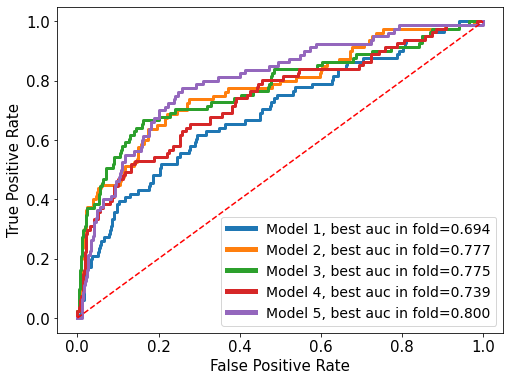

In [114]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,6))
plt.plot(best_auc_model1[0],best_auc_model1[1],label="{}, best auc in fold={:.3f}".format("Model 1",best_auc_model1[2]),linewidth=3)
plt.plot(best_auc_model2[0],best_auc_model2[1],label="{}, best auc in fold={:.3f}".format("Model 2",best_auc_model2[2]),linewidth=3)
plt.plot(best_auc_model3[0],best_auc_model3[1],label="{}, best auc in fold={:.3f}".format("Model 3",best_auc_model3[2]),linewidth=3)
plt.plot(best_auc_model4[0],best_auc_model4[1],label="{}, best auc in fold={:.3f}".format("Model 4",best_auc_model4[2]),linewidth=3)
plt.plot(best_auc_model5[0],best_auc_model5[1],label="{}, best auc in fold={:.3f}".format("Model 5",best_auc_model5[2]),linewidth=3)
# plt.title('Perbandingan Grafik ROC pada Variasi Penggunaan Fitur Protein', fontsize=15)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
leg = plt.legend(loc="lower right", prop={'size': 14})
for legobj in leg.legendHandles:  
    legobj.set_linewidth(5.0)
plt.show()

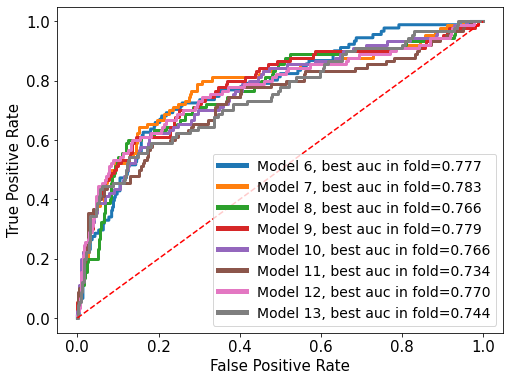

In [115]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,6))
plt.plot(best_auc_model6[0],best_auc_model6[1],label="{}, best auc in fold={:.3f}".format("Model 6",best_auc_model6[2]),linewidth=3)
plt.plot(best_auc_model7[0],best_auc_model7[1],label="{}, best auc in fold={:.3f}".format("Model 7",best_auc_model7[2]),linewidth=3)
plt.plot(best_auc_model8[0],best_auc_model8[1],label="{}, best auc in fold={:.3f}".format("Model 8",best_auc_model8[2]),linewidth=3)
plt.plot(best_auc_model9[0],best_auc_model9[1],label="{}, best auc in fold={:.3f}".format("Model 9",best_auc_model9[2]),linewidth=3)
plt.plot(best_auc_model10[0],best_auc_model10[1],label="{}, best auc in fold={:.3f}".format("Model 10",best_auc_model10[2]),linewidth=3)
plt.plot(best_auc_model11[0],best_auc_model11[1],label="{}, best auc in fold={:.3f}".format("Model 11",best_auc_model11[2]),linewidth=3)
plt.plot(best_auc_model12[0],best_auc_model12[1],label="{}, best auc in fold={:.3f}".format("Model 12",best_auc_model12[2]),linewidth=3)
plt.plot(best_auc_model13[0],best_auc_model13[1],label="{}, best auc in fold={:.3f}".format("Model 13",best_auc_model13[2]),linewidth=3)
# plt.title('Perbandingan Grafik ROC pada Variasi Penggunaan Fitur Protein', fontsize=15)
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
leg = plt.legend(loc="lower right", prop={'size': 14})
for legobj in leg.legendHandles:  
    legobj.set_linewidth(5.0)
plt.show()

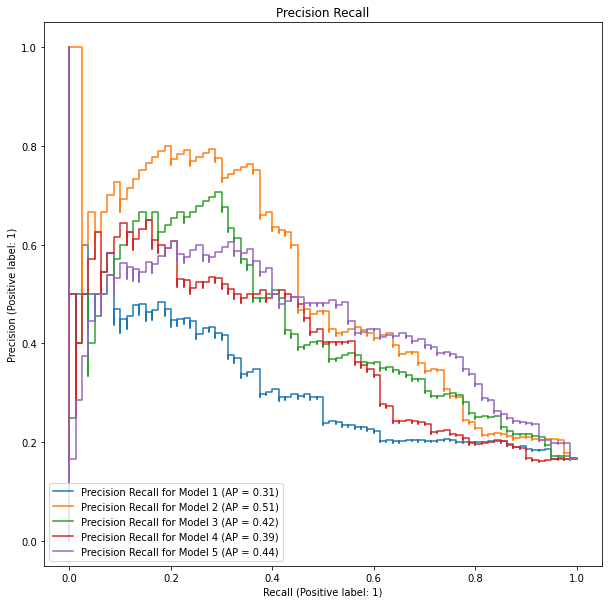

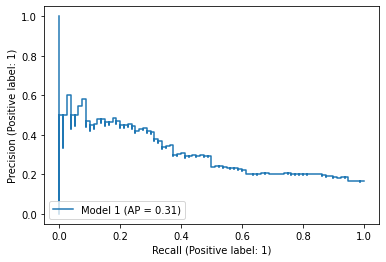

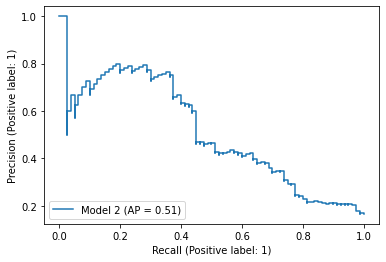

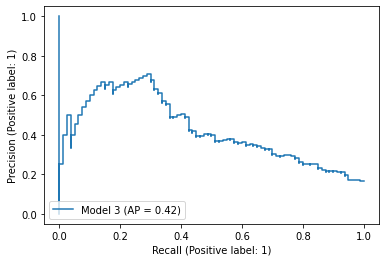

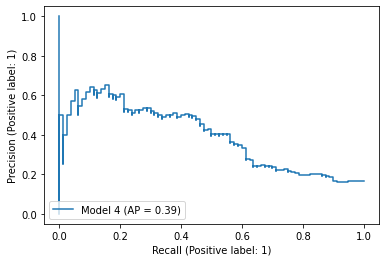

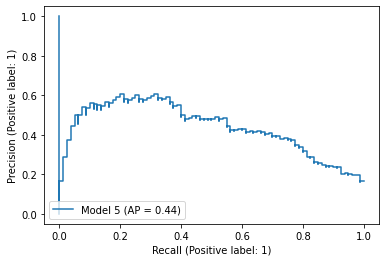

In [124]:
from sklearn.metrics import PrecisionRecallDisplay


_, ax = plt.subplots(figsize=(10, 10))
display = PrecisionRecallDisplay.from_predictions(y_test_model1, yhat_model1, name="Model 1")
display.plot(ax = ax, name = 'Precision Recall for Model 1')
_ = display.ax_.set_title("Precision Recall")

display = PrecisionRecallDisplay.from_predictions(y_test_model2, yhat_model2, name="Model 2")
display.plot(ax = ax, name = 'Precision Recall for Model 2')
_ = display.ax_.set_title("Precision Recall")

display = PrecisionRecallDisplay.from_predictions(y_test_model3, yhat_model3, name="Model 3")
display.plot(ax = ax, name = 'Precision Recall for Model 3')
_ = display.ax_.set_title("Precision Recall")
display = PrecisionRecallDisplay.from_predictions(y_test_model4, yhat_model4, name="Model 4")
display.plot(ax = ax, name = 'Precision Recall for Model 4')
_ = display.ax_.set_title("Precision Recall")
display = PrecisionRecallDisplay.from_predictions(y_test_model5, yhat_model5, name="Model 5")
display.plot(ax = ax, name = 'Precision Recall for Model 5')
_ = display.ax_.set_title("Precision Recall")
plt.show()

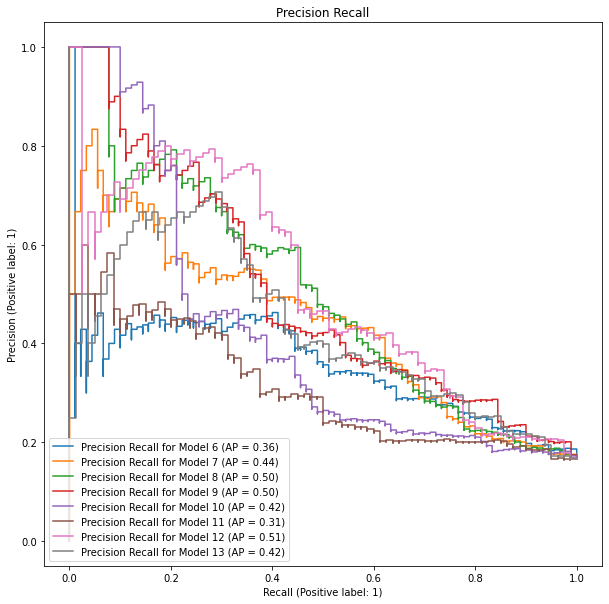

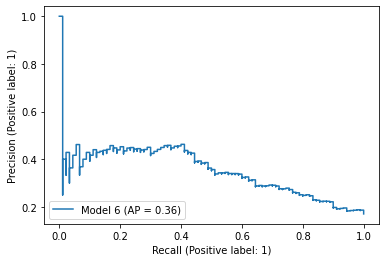

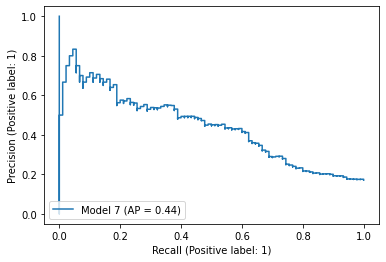

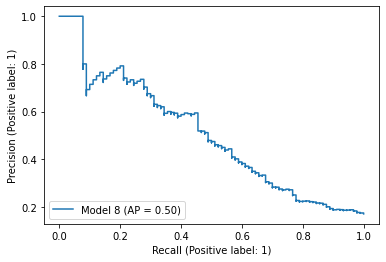

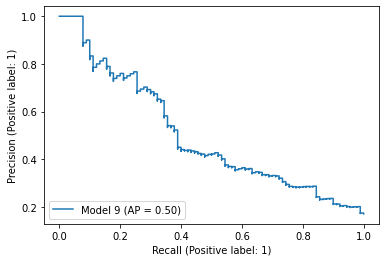

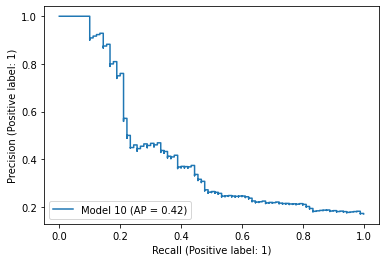

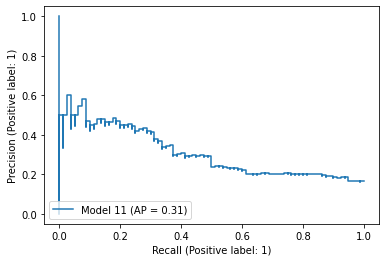

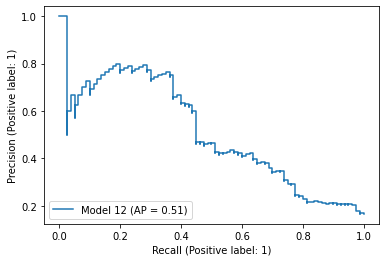

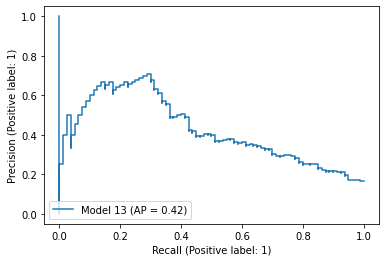

In [126]:
from sklearn.metrics import PrecisionRecallDisplay


_, ax = plt.subplots(figsize=(10, 10))
display = PrecisionRecallDisplay.from_predictions(y_test_model6, yhat_model6, name="Model 6")
display.plot(ax = ax, name = 'Precision Recall for Model 6')
_ = display.ax_.set_title("Precision Recall")

display = PrecisionRecallDisplay.from_predictions(y_test_model7, yhat_model7, name="Model 7")
display.plot(ax = ax, name = 'Precision Recall for Model 7')
_ = display.ax_.set_title("Precision Recall")

display = PrecisionRecallDisplay.from_predictions(y_test_model8, yhat_model8, name="Model 8")
display.plot(ax = ax, name = 'Precision Recall for Model 8')
_ = display.ax_.set_title("Precision Recall")
display = PrecisionRecallDisplay.from_predictions(y_test_model9, yhat_model9, name="Model 9")
display.plot(ax = ax, name = 'Precision Recall for Model 9')
_ = display.ax_.set_title("Precision Recall")
display = PrecisionRecallDisplay.from_predictions(y_test_model10, yhat_model10, name="Model 10")
display.plot(ax = ax, name = 'Precision Recall for Model 10')
_ = display.ax_.set_title("Precision Recall")

display = PrecisionRecallDisplay.from_predictions(y_test_model1, yhat_model1, name="Model 11")
display.plot(ax = ax, name = 'Precision Recall for Model 11')
_ = display.ax_.set_title("Precision Recall")

display = PrecisionRecallDisplay.from_predictions(y_test_model2, yhat_model2, name="Model 12")
display.plot(ax = ax, name = 'Precision Recall for Model 12')
_ = display.ax_.set_title("Precision Recall")

display = PrecisionRecallDisplay.from_predictions(y_test_model3, yhat_model3, name="Model 13")
display.plot(ax = ax, name = 'Precision Recall for Model 13')
_ = display.ax_.set_title("Precision Recall")
plt.show()

In [127]:
res_all_combine = [res_all_model1,res_all_model2,res_all_model3,res_all_model4,res_all_model5]
res_all_combine

[[[0.822680412371134,
   0.8206185567010309,
   0.8206185567010309,
   0.8309278350515464,
   0.8326446280991735],
  [0.1728395061728395,
   0.19753086419753085,
   0.09876543209876543,
   0.07407407407407407,
   0.1375],
  [0.42424242424242425,
   0.42105263157894735,
   0.36363636363636365,
   0.46153846153846156,
   0.4782608695652174],
  [0.6480870309253148,
   0.6002628040581836,
   0.6466507761887299,
   0.6937110377704437,
   0.6510519801980199],
  [0.2456140350877193,
   0.2689075630252101,
   0.1553398058252427,
   0.12765957446808512,
   0.21359223300970873]],
 [[0.8329896907216495,
   0.843298969072165,
   0.822680412371134,
   0.7917525773195876,
   0.8657024793388429],
  [0.24691358024691357,
   0.2962962962962963,
   0.4074074074074074,
   0.35802469135802467,
   0.4],
  [0.5,
   0.5581395348837209,
   0.4647887323943662,
   0.3717948717948718,
   0.6530612244897959],
  [0.6915719349712749,
   0.7291590270138125,
   0.7433687813225767,
   0.6753453123090086,
   0.77654702

In [132]:
res_model1 = pd.DataFrame(res_all_combine[0], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model2 = pd.DataFrame(res_all_combine[1], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model3 = pd.DataFrame(res_all_combine[2], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model4 = pd.DataFrame(res_all_combine[3], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model5 = pd.DataFrame(res_all_combine[4], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model1["Dataset"] = ["Model 1" for i in range(res_model1.shape[0])]
res_model2["Dataset"] = ["Model 2" for i in range(res_model2.shape[0])]
res_model3["Dataset"] = ["Model 3" for i in range(res_model3.shape[0])]
res_model4["Dataset"] = ["Model 4" for i in range(res_model4.shape[0])]
res_model5["Dataset"] = ["Model 5" for i in range(res_model5.shape[0])]

res_combine = pd.concat([res_model1,res_model2,res_model3,res_model4,res_model5], axis = 0)

<Figure size 720x576 with 0 Axes>

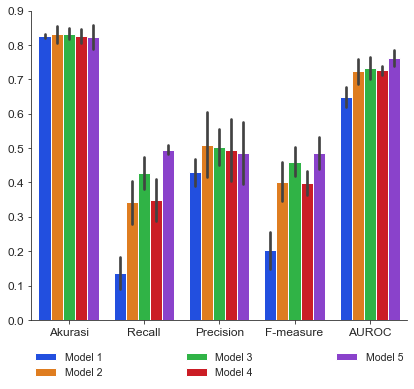

In [133]:
df_res = res_combine.copy()
df_res = pd.melt(df_res, id_vars=["Dataset"], value_vars=["Akurasi","Recall","Precision","F-measure","AUROC"])

import seaborn as sns
sns.set_style("ticks")
plt.figure(figsize = (10,8))
g = sns.catplot(x="variable", y="value", hue="Dataset", data=df_res, height=5, kind="bar", palette="bright", aspect = 1.2, legend = False, ci = "sd")
plt.legend(bbox_to_anchor=(0., -.2, 1., .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0., frameon = False, prop={'size': 10.5})
g.set_xticklabels(fontsize=12)
g.set_yticklabels(fontsize=12)
g.set_xlabels("")
g.set_ylabels("")

In [140]:
res_all_combine = [res_all_model6,res_all_model7,res_all_model8,res_all_model9,res_all_model10,res_all_model11,res_all_model12,res_all_model13]
res_all_combine

[[[0.7996219281663516,
   0.8034026465028355,
   0.8049242424242424,
   0.8068181818181818,
   0.8087121212121212],
  [0.5604395604395604,
   0.38461538461538464,
   0.3333333333333333,
   0.4777777777777778,
   0.4111111111111111],
  [0.4358974358974359,
   0.42168674698795183,
   0.410958904109589,
   0.4387755102040816,
   0.43529411764705883],
  [0.7765442320236841,
   0.7209217722916352,
   0.7218036529680364,
   0.7471714865550482,
   0.7276889903602232],
  [0.49038461538461536,
   0.40229885057471265,
   0.36809815950920244,
   0.45744680851063835,
   0.4228571428571428]],
 [[0.7844990548204159,
   0.831758034026465,
   0.8162878787878788,
   0.8162878787878788,
   0.8428030303030303],
  [0.26373626373626374,
   0.4175824175824176,
   0.5222222222222223,
   0.4,
   0.18888888888888888],
  [0.3380281690140845,
   0.5135135135135135,
   0.46534653465346537,
   0.45569620253164556,
   0.6296296296296297],
  [0.7171960459631693,
   0.714486426815194,
   0.7833840690005074,
   0.7278

In [146]:
res_model6 = pd.DataFrame(res_all_combine[0], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model7 = pd.DataFrame(res_all_combine[1], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model8 = pd.DataFrame(res_all_combine[2], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model9 = pd.DataFrame(res_all_combine[3], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model10 = pd.DataFrame(res_all_combine[4], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model11 = pd.DataFrame(res_all_combine[4], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model12 = pd.DataFrame(res_all_combine[4], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model13 = pd.DataFrame(res_all_combine[4], index = ["Akurasi", "Recall", "Precision", "AUROC", "F-measure"]).transpose()
res_model6["Dataset"] = ["Model 6" for i in range(res_model6.shape[0])]
res_model7["Dataset"] = ["Model 7" for i in range(res_model7.shape[0])]
res_model8["Dataset"] = ["Model 8" for i in range(res_model8.shape[0])]
res_model9["Dataset"] = ["Model 9" for i in range(res_model9.shape[0])]
res_model0["Dataset"] = ["Model 10" for i in range(res_model0.shape[0])]
res_model11["Dataset"] = ["Model 11" for i in range(res_model11.shape[0])]
res_model12["Dataset"] = ["Model 12" for i in range(res_model12.shape[0])]
res_model13["Dataset"] = ["Model 13" for i in range(res_model13.shape[0])]
res_combine = pd.concat([res_model6,res_model7,res_model8,res_model9,res_model10,res_model11,res_model12,res_model13], axis = 0)

<Figure size 720x576 with 0 Axes>

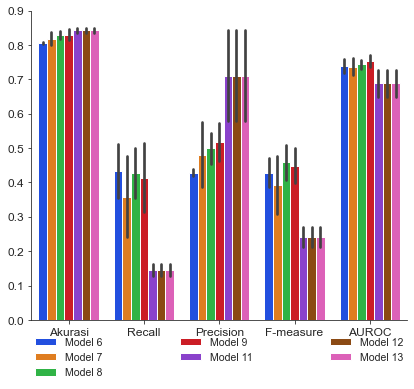

In [147]:
df_res = res_combine.copy()
df_res = pd.melt(df_res, id_vars=["Dataset"], value_vars=["Akurasi","Recall","Precision","F-measure","AUROC"])

import seaborn as sns
sns.set_style("ticks")
plt.figure(figsize = (10,8))
g = sns.catplot(x="variable", y="value", hue="Dataset", data=df_res, height=5, kind="bar", palette="bright", aspect = 1.2, legend = False, ci = "sd")
plt.legend(bbox_to_anchor=(0., -.2, 1., .102), loc='lower left', ncol=3, mode="expand", borderaxespad=0., frameon = False, prop={'size': 10.5})
g.set_xticklabels(fontsize=12)
g.set_yticklabels(fontsize=12)
g.set_xlabels("")
g.set_ylabels("")